# Importing libs

In [1]:
import sys, os
import numpy as np
import pandas as pd
from copy import deepcopy
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(''), os.path.pardir))) # if you run this notebook from its current folder on our GitHub, you may need this line
from utils.genlink import DataProcessor # core class, all graphs are processed there
from utils.genlink import Trainer # you can train your nets using our algorithms with this class
from utils.genlink import NullSimulator # you can simulate graphs with that class
from utils.models import GL_TAGConv_3l_512h_w_k3_gnorm # here is one of our best gnn, see all available classes in utils.models, they all can be used absolutely identical

In [2]:
# let's also fix our seed globally
seed = 42

In [3]:
# use RAM efficient sampling (it will be explained further)
use_ram_efficient_sampler = False

Disclamer: there are not so many internal code asserts across current GENLINK repository, so, please, follow instructions as all this code is not designed to work with what it's not designed to work for :)

# Graph simulation and visualization

Let's simulate very simple graph with 4 populations. Initially, you need to pass 3 arguments to the `NullSimulator` class:

* `num_classes` - how many populations you want to simulat (int)
* `edge_probs` - edge probability between every population, should be matrix with the shape `(num_classes, num_classes)`, each values must be less than 1.0, there are no any additional reuirements
* `mean_weight` - $\lambda$ paramener (mean) in exponential distribution, should be matrix with the shape `(num_classes, num_classes)`, we will sample edge weights from exponential distribution

Remember that `edge_probs[i, j]` relate to `mean_weight[i, j]` and both matrices must be symmetrical

In [4]:
ep = np.array([[0.48, 0.02, 0.01, 0.02],
               [0.02, 0.12, 0.1, 0.08],
               [0.01, 0.1, 0.56, 0.32],
               [0.02, 0.08, 0.32, 0.61]])

mw = np.array([[29.16, 10.77, 10.05, 11.54],
               [10.77, 14.13, 12.49, 12.21],
               [10.05, 12.49, 24.76, 19.13],
               [11.54, 12.21, 19.13, 31.08]])

In [5]:
assert np.all(ep == ep.T)
assert np.all(mw == mw.T)

In [6]:
ns = NullSimulator(num_classes=4, 
                   edge_probs=ep, 
                   mean_weight=mw)

Now you need to specify population sizes and generate internal simulator objects (`counts, means, pop_index`). Assuming `ns` is you `NullSimulator` object, you should call `generate_matrices` method that takes:

* `population_sizes` - a numpy array with the desired number of individuals in each population (its like `population_sizes[i]` relate to `edge_probs[i, i]` and `mean_weights[i, i]`)
* `rng` - just numpy random number generator, fixed by seed

In [7]:
ps = np.array([12, 20, 16, 8])

In [8]:
counts, means, pop_index = ns.generate_matrices(population_sizes=ps,
                                                rng=np.random.default_rng(seed))

Finally, call `simulate_graph` method. Specify the path you want to save you graph to

In [9]:
graph_file_path = f'{os.environ.get("HOME")}/GENLINK/data/tutorial/tutorial_graph.csv'
ns.simulate_graph(means=means,
                  counts=counts, 
                  pop_index=pop_index,
                  path=graph_file_path)

Now you get the graph in readable `.csv` format where each row contains edge with its properties. Here is column breakdown:

* `node_id1` - name of node in simulated graph
* `node_id2` - name of node in simulated graph
* `label_id1` - name of population in simulated graph that node in `node_id1` belongs to
* `label_id2` - name of population in simulated graph that node in `node_id2` belongs to
* `ibd_sum` - as each row is an edge, so this is an edge weight
* `ibd_n` - number of IBD segments, it's always 1 because we can't simulate them (keep just for consistency with real data)

In [10]:
pd.read_csv(graph_file_path)

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n
0,node_1,node_0,P0,P0,79.181347,1
1,node_2,node_0,P0,P0,9.701131,1
2,node_4,node_0,P0,P0,28.309291,1
3,node_5,node_0,P0,P0,14.826807,1
4,node_5,node_2,P0,P0,11.424783,1
...,...,...,...,...,...,...
230,node_55,node_47,P3,P2,6.396516,1
231,node_55,node_49,P3,P3,46.897711,1
232,node_55,node_50,P3,P3,25.709908,1
233,node_55,node_52,P3,P3,156.257226,1


Remember, isolated nodes won't be in that file at all because isolated nodes don't have edges to any other nodes in graph. Generated graph can have less nodes than you specified because some of them may become isolated during simulation (its okay because they are absolutely useless for us)

It's time to visualisation! Here we are going to use our `DataProcessor` class. Here are its arguments:

* `path` - peth to the `.csv` file that we've generated previously (you can use your own file as well)
* `is_path_object` - should be `False` if `path` is a string and `True` if `path` is already `pd.DataFrame`
* `disable_printing` - should be `True` if you want to supress almost all logs, otherwise `False`
* `dataset_name` - whatever name for current dataset you want (can be `None` as well)
* `no_mask_class_in_df` - must be `True` if initial `.csv` file does not contain masked nodes, otherwise `False` 

In [11]:
dp = DataProcessor(path=graph_file_path,
                   is_path_object=False,
                   disable_printing=False,
                   dataset_name='tutorial_dataset',
                   no_mask_class_in_df=True)

You can visualise your graph by simply calling the method `visualisze_initial_graph`. It has the following parameters:

* `id_of_node_to_draw_neighbours_for` - if you want, you can specify one node id here (int), then function will plot only neighbours of that node
* `figsize_in_px` - width and height of the picture in pixels (int)
* `base_node_size` - size of nodes
* `selected_node_size` - size of specified node
* `plot_node_labels` - `True` if you want to plot node labels, otherwise `False`
* `plot_real_node_labels` - `True` if you want to plot real node names (as in your initial dataframe, namely, before renaming), otherwise `False`
* `node_labels_size` - size of node labels
* `node_label_font_color` - color of nodel labels
* `legend_size` - size of the legend
* `save_path` - path in case you want to save you picture

Thickness of edges is proportional to the edge weights

/disk/10tb/home/shmelev/GENLINK/utils/genlink.py:1805: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([],[], c=clr, label=f'{self.class_to_int_mapping[i]}')


<Figure size 640x480 with 0 Axes>

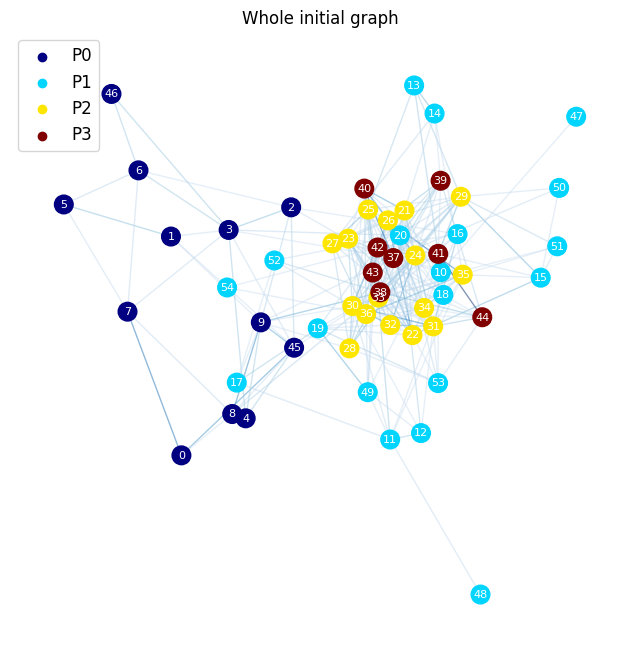

In [12]:
dp.visualisze_initial_graph(id_of_node_to_draw_neighbours_for=None,
                            figsize_in_px=800,
                            base_node_size=180,
                            selected_node_size=300, # won't be used here because 1st argument if None
                            plot_node_labels=True,
                            plot_real_node_labels=False,
                            node_labels_size=8,
                            node_label_font_color='white',
                            legend_size=12,
                            save_path=None)

Now let's try to plot, for example, `node_10`. Firstly, we need to find its name after renaming

In [13]:
print(f"Node_10 has id {dp.node_names_to_int_mapping['node_10']} after renaming")

Node_10 has id 8 after renaming


Now let's plot its neighbours

<Figure size 640x480 with 0 Axes>

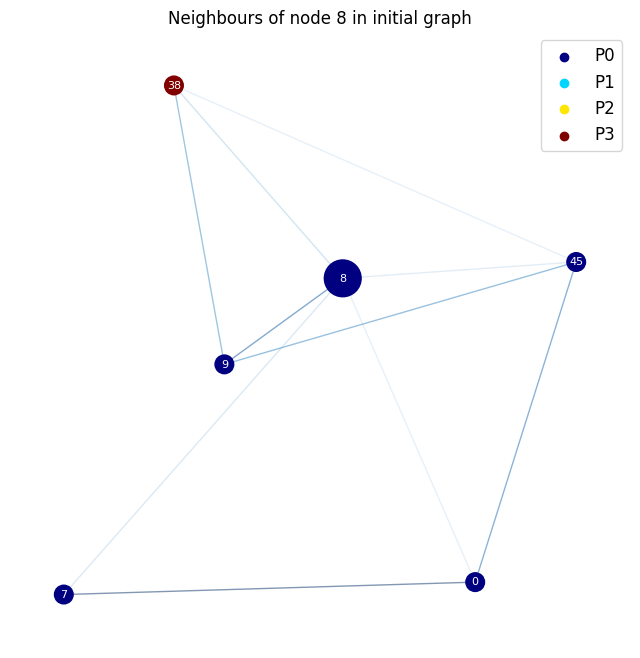

In [14]:
dp.visualisze_initial_graph(id_of_node_to_draw_neighbours_for=8,
                            figsize_in_px=800,
                            base_node_size=180,
                            selected_node_size=700,
                            plot_node_labels=True,
                            plot_real_node_labels=False,
                            node_labels_size=8,
                            node_label_font_color='white',
                            legend_size=12,
                            save_path=None)

You can plot real node names as well

<Figure size 640x480 with 0 Axes>

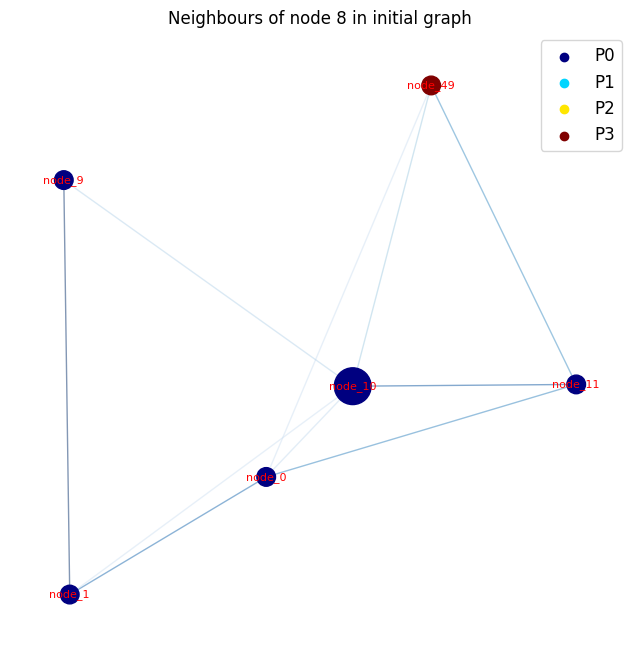

In [15]:
dp.visualisze_initial_graph(id_of_node_to_draw_neighbours_for=8,
                            figsize_in_px=800,
                            base_node_size=180,
                            selected_node_size=700,
                            plot_node_labels=True,
                            plot_real_node_labels=True,
                            node_labels_size=8,
                            node_label_font_color='red',
                            legend_size=12,
                            save_path=None)

If you want to access graph in `networkx` format directly, you can do it like that

In [16]:
dp.nx_graph

You can access node attributes of each node and edge like that

In [17]:
print('Some nodes: ', list(dp.nx_graph.nodes)[:10])
print('Some edges: ', list(dp.nx_graph.edges)[:10])
print(f'Node attributes of node "{dp.int_to_node_names_mapping[0]}": ', dp.nx_graph.nodes[0])
print(f'Edge attributes of edge between nodes "{dp.int_to_node_names_mapping[0]}" and "{dp.int_to_node_names_mapping[7]}": ', dp.nx_graph.edges[0, 7])

Some nodes:  [0, 45, 1, 2, 3, 46, 4, 5, 6, 7]
Some edges:  [(0, 45), (0, 7), (0, 8), (45, 1), (45, 2), (45, 3), (45, 4), (45, 8), (45, 9), (45, 38)]
Node attributes of node "node_1":  {'class': 0, 'mask': True}
Edge attributes of edge between nodes "node_1" and "node_9":  {'ibd_sum': 107.36131453757191, 'ibd_n': 1}


You can convert classes of each node to readable names like that

In [18]:
dp.classes[dp.nx_graph.nodes[0]['class']]

'P0'

Suppose you need to visualise matrices with edge probabilities between classes. For that need firstly call `compute_simulation_params` and then `plot_simulated_probs` with the following available parameters:

* `save_path` - path for saving this figure
* `dataset_name` - name of the dataset that will be displayed in title

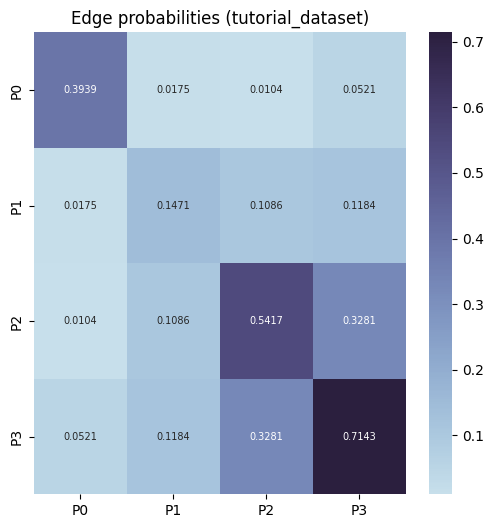

In [19]:
dp.compute_simulation_params()
dp.plot_simulated_probs(dataset_name='tutorial_dataset')

Visualisation of edge weights can be done the same way (just call function `plot_simulated_weights` with the same parameters)

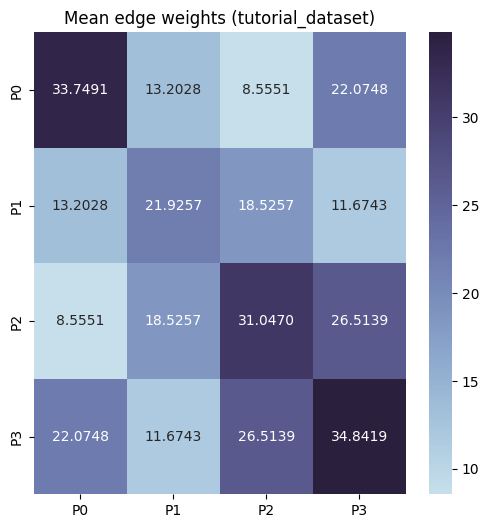

In [20]:
dp.plot_simulated_weights(dataset_name='tutorial_dataset')

To plot edge weight distribution between each class, use function `plot_edge_weight_distribution` with the following parameters:

* `fig_size` - size of the picture
* `dataset_name` - name of the dataset that will be displayed in title
* `title_pos` - you can adjust position of the title with this parameter
* `title_font_size` - you can change font size of title with this parameter
* `save_path` - path for saving this figure
* `custom_class_names` - (list of strings), if your class names are too long, you can assign the list of other class names according to the `dp.classes`
* `fontsize` - you can change font size of labels with this parameter

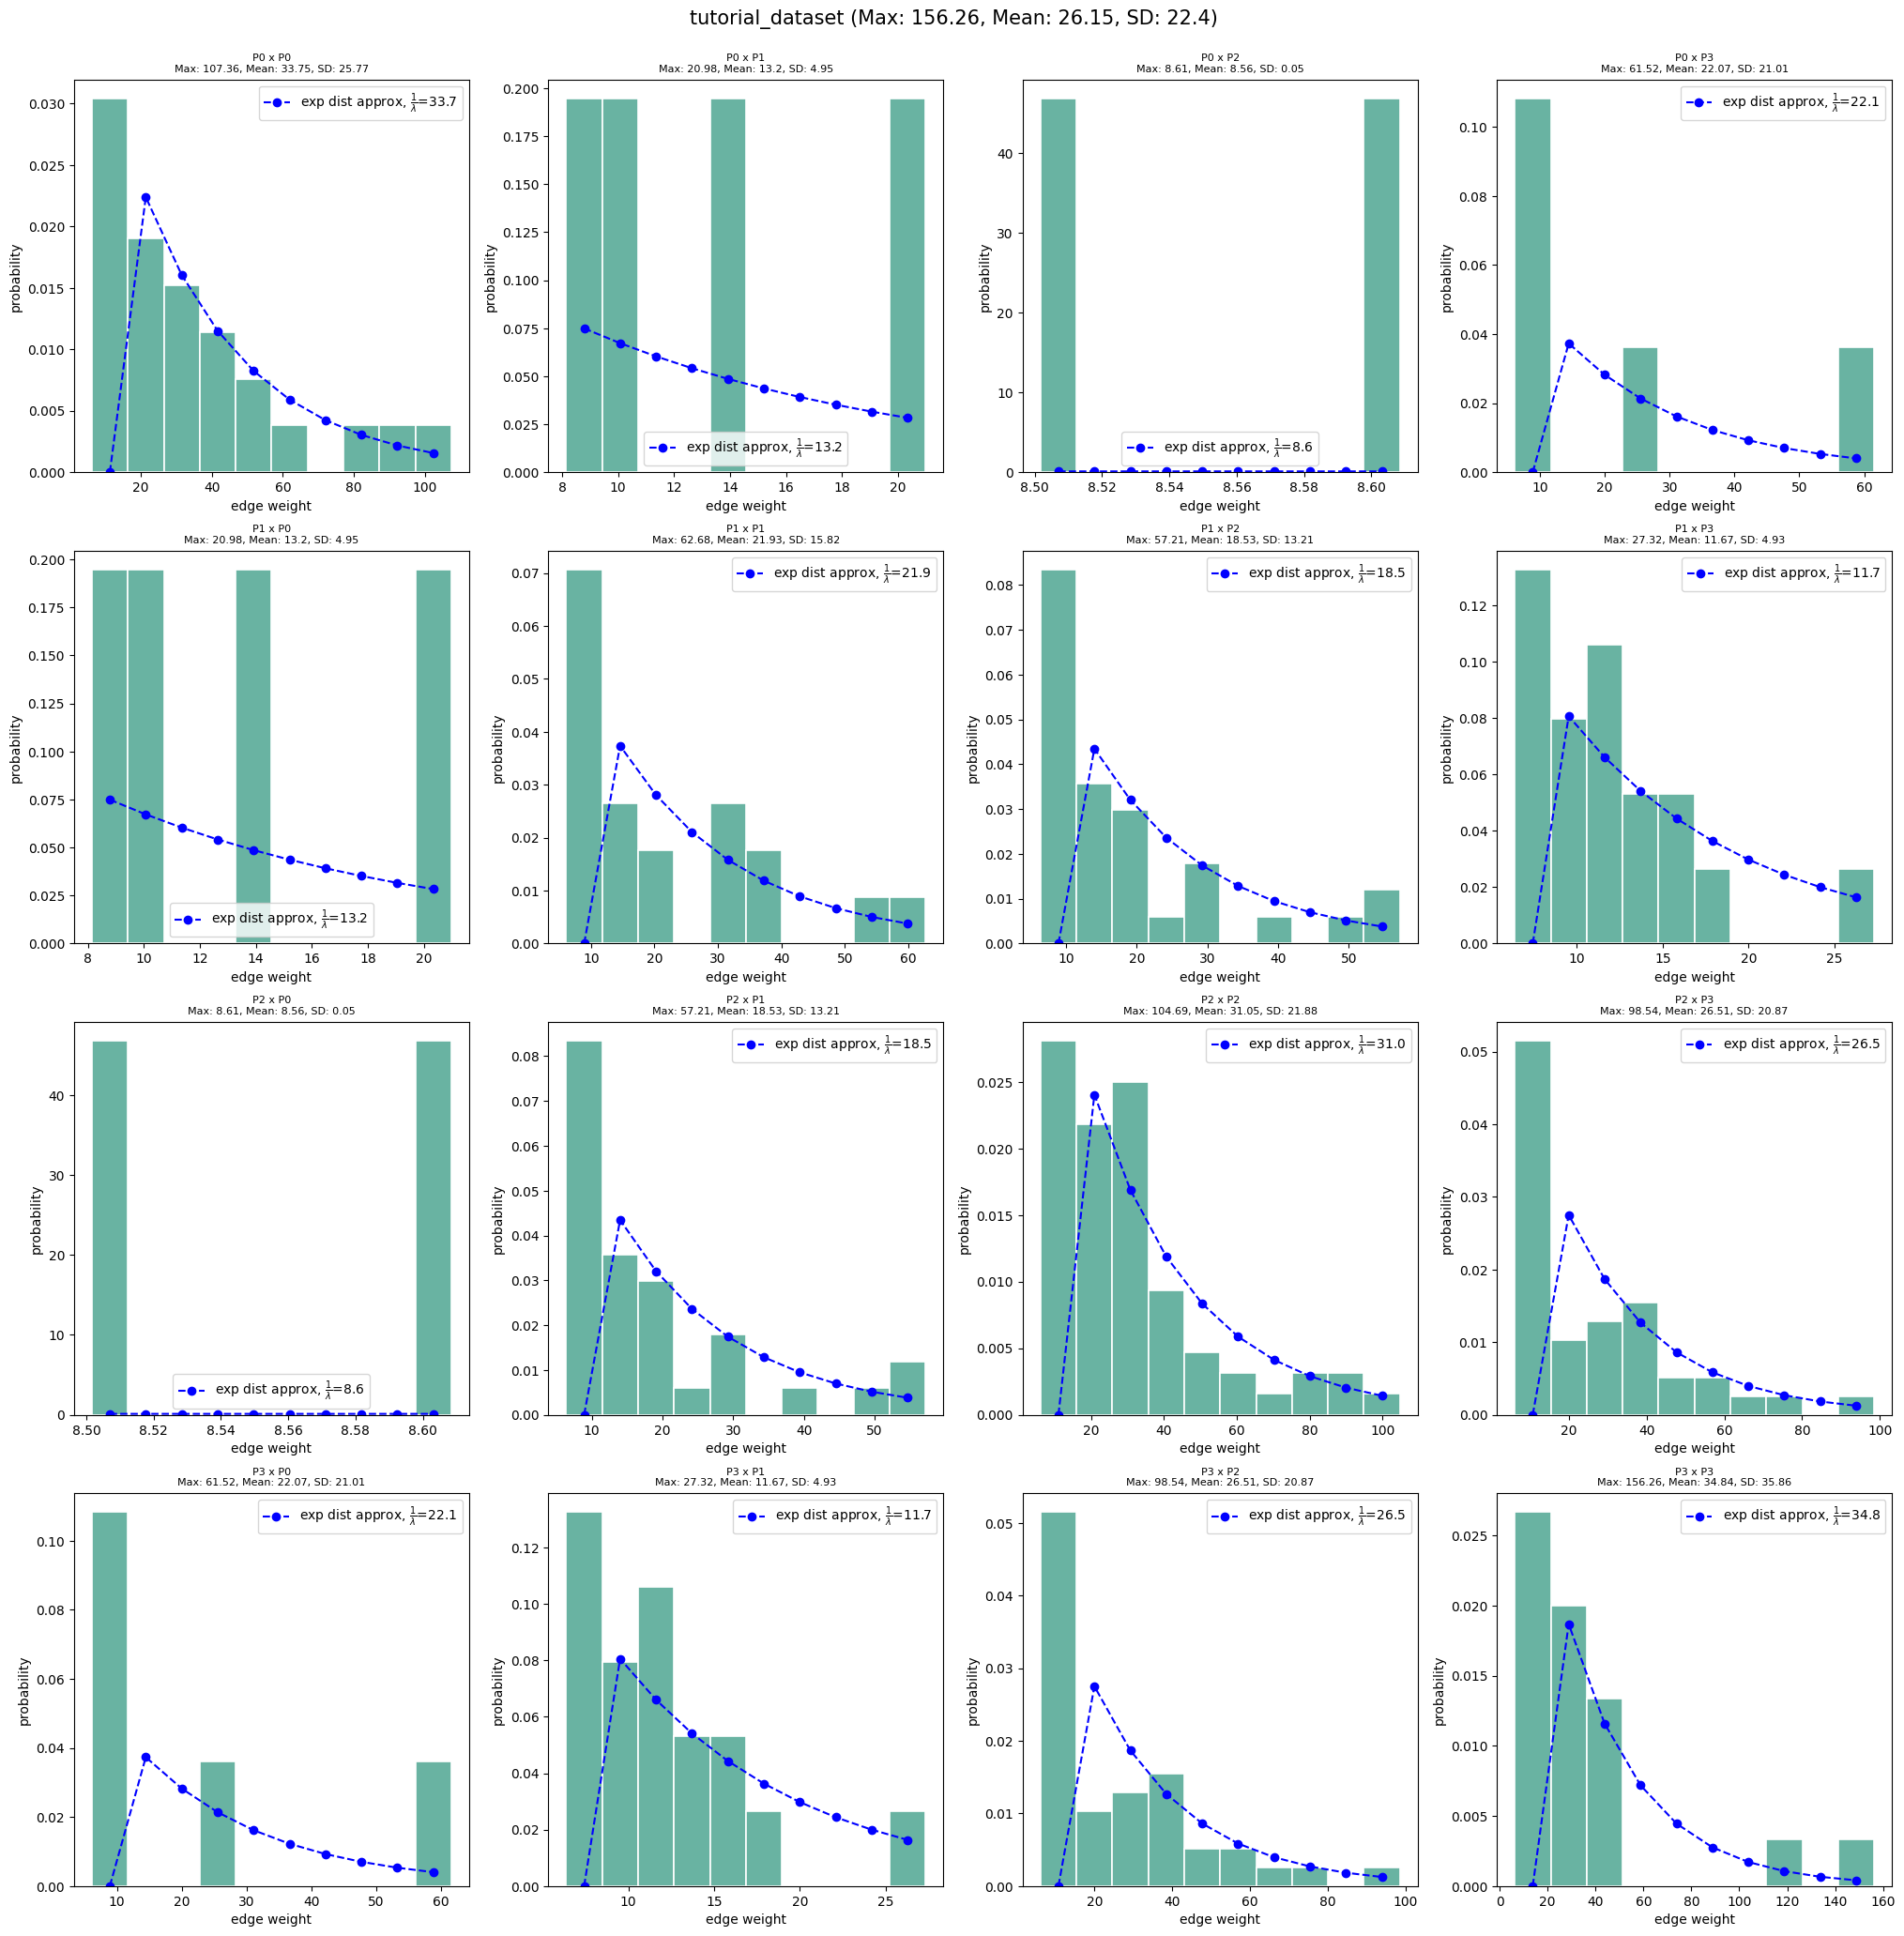

In [21]:
# I always recommend to save all pictures in PDF (just use .pdf at the end of the picture name in path)
dp.plot_edge_weight_distribution(fig_size=(25, 25), 
                                 dataset_name='tutorial_dataset', 
                                 save_path=None,
                                 title_pos=0.91, 
                                 title_font_size=15)

Finally, let's calculate all important characteristics of the graph. You need to call function `get_graph_features` with the following parameters:

* `fig_path` - where to save stats in JSON format as well as generated pictures
* `fig_size` - size of some pictures
* `picture_only` - `True` if you don't want to calculate computationally heavy parameters, `False` otherwise which is default (deprecated)
* `dataset_name` - name of the dataset that will be displayed in title

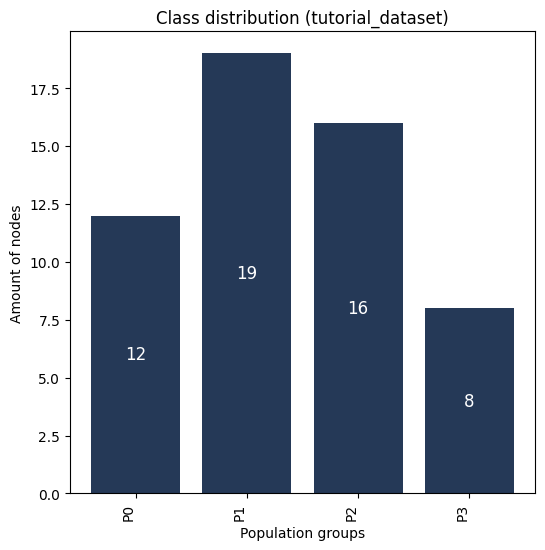

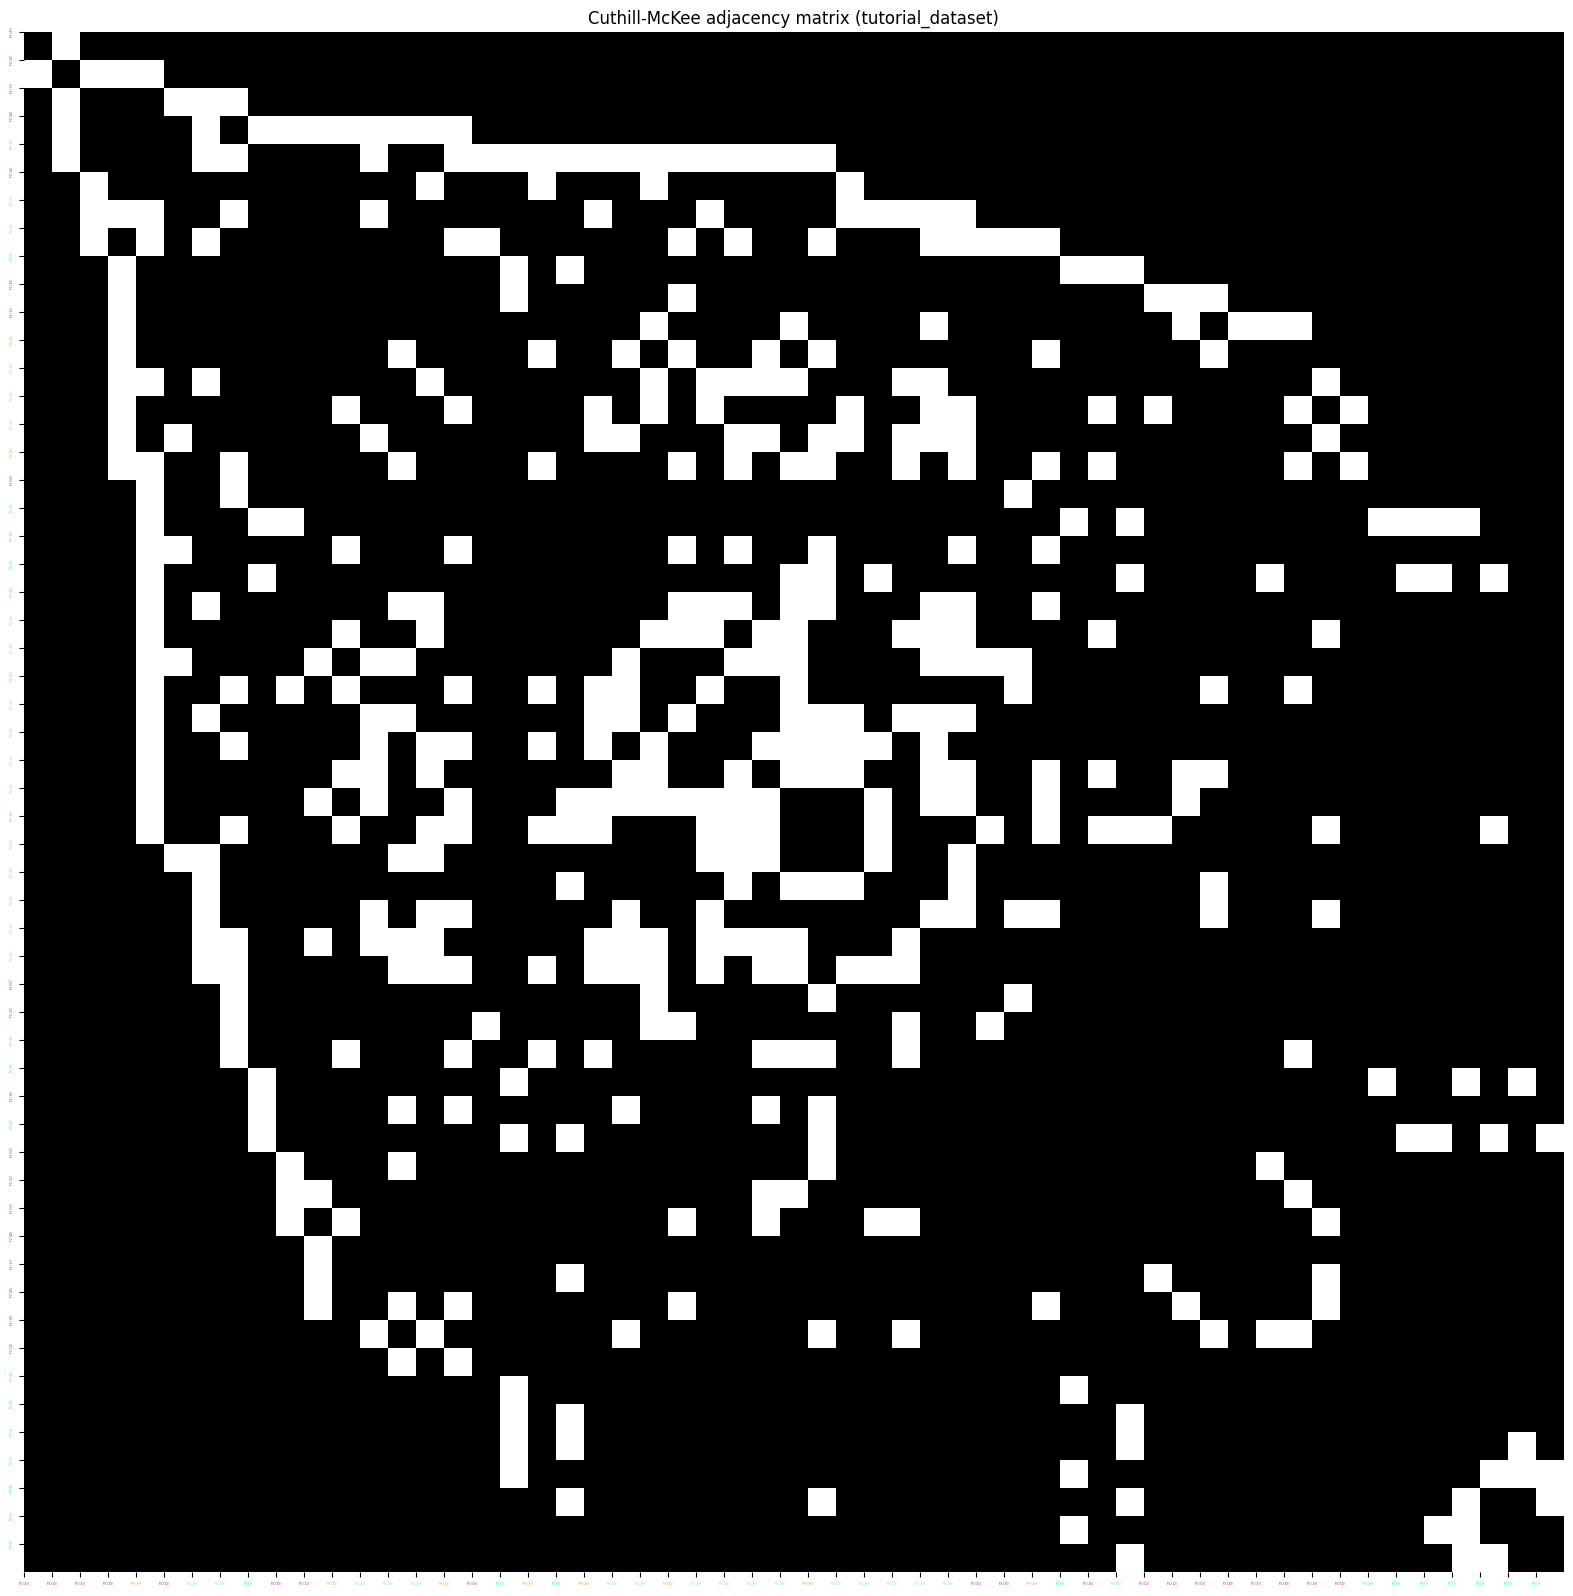

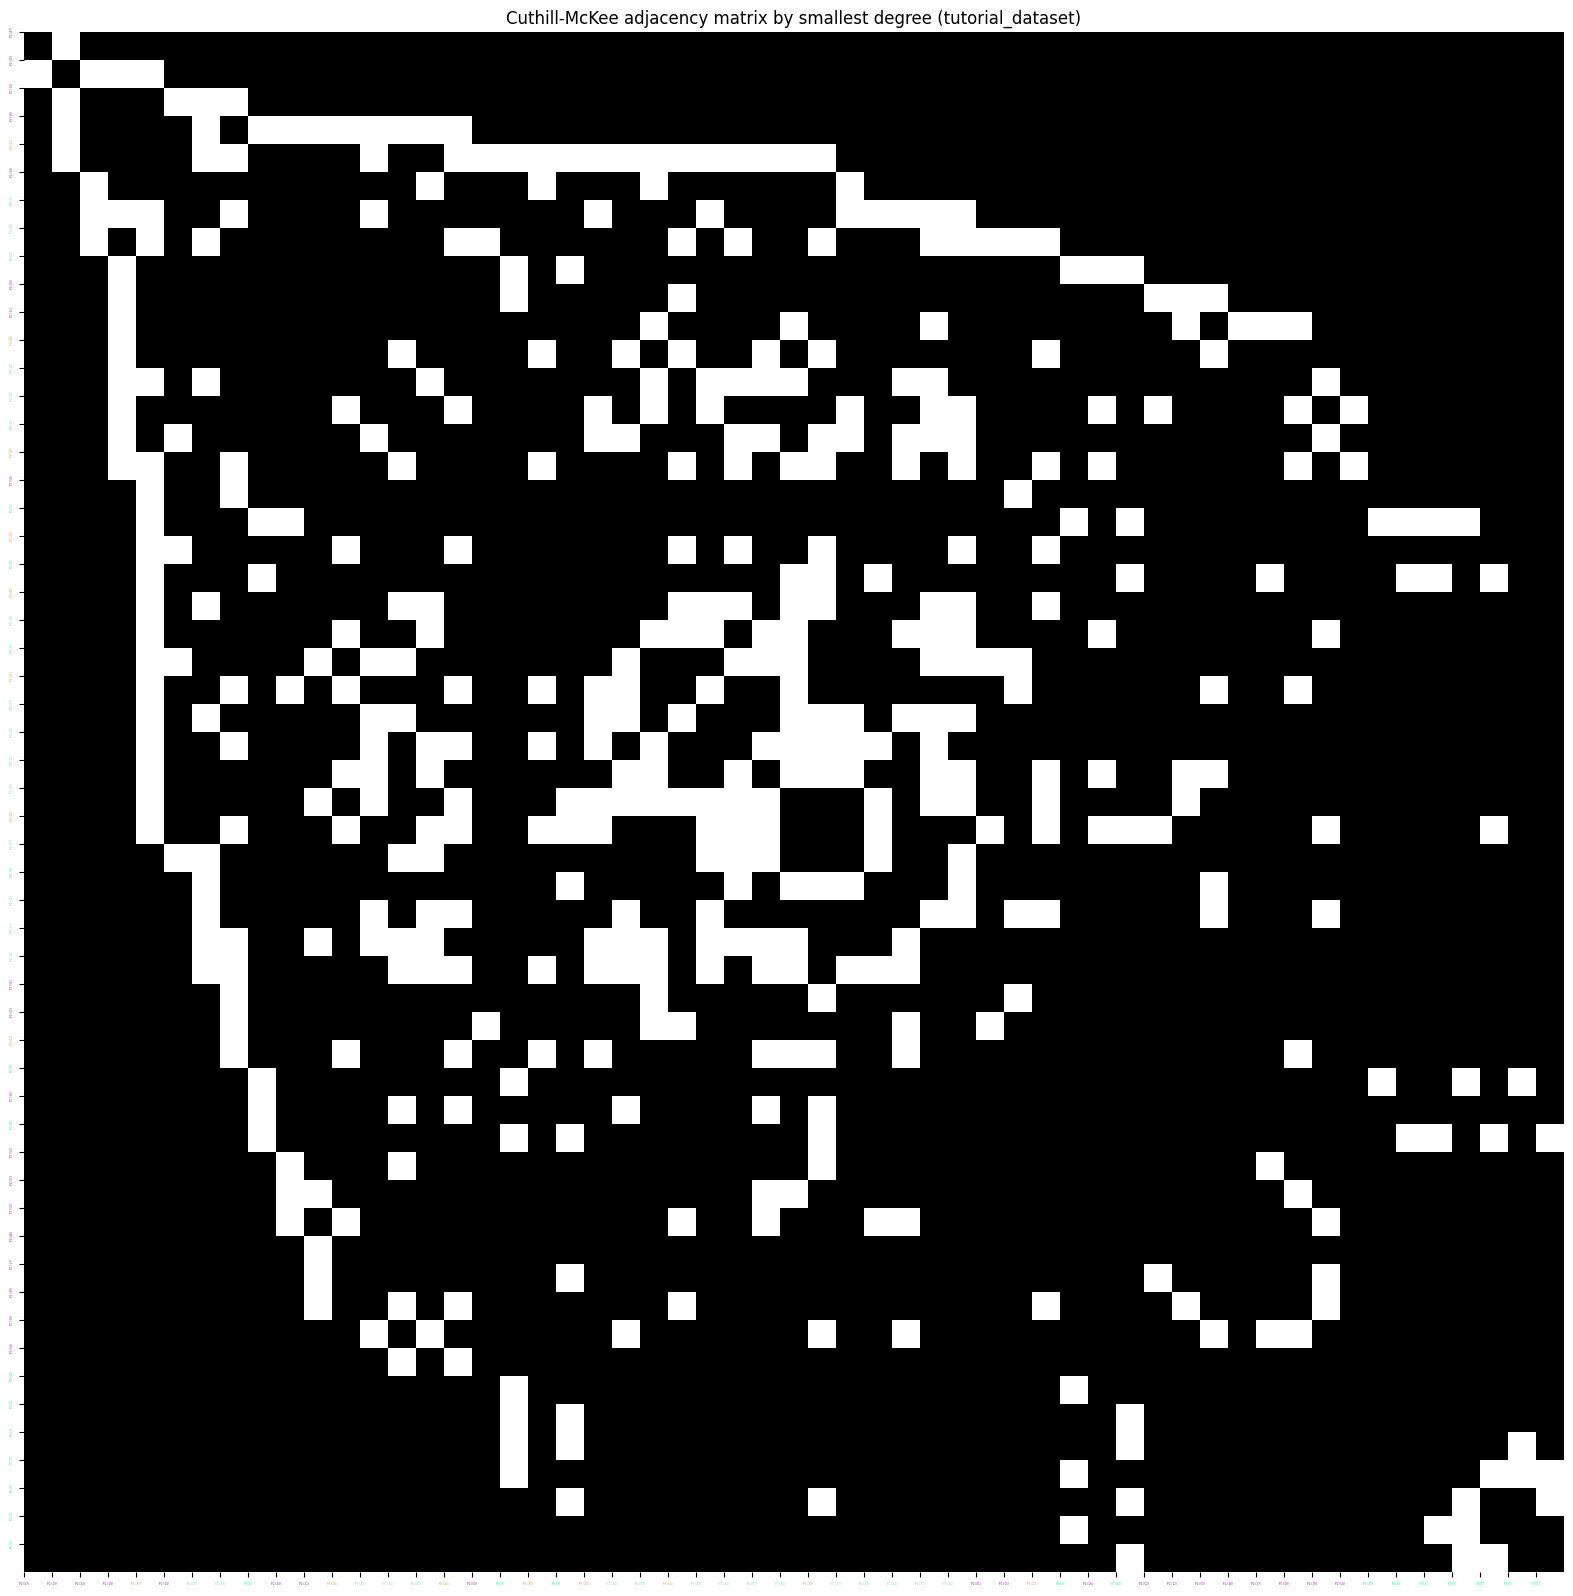

/disk/10tb/home/shmelev/GENLINK/utils/genlink.py:812: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([],[], c=v, label=k)


<Figure size 640x480 with 0 Axes>

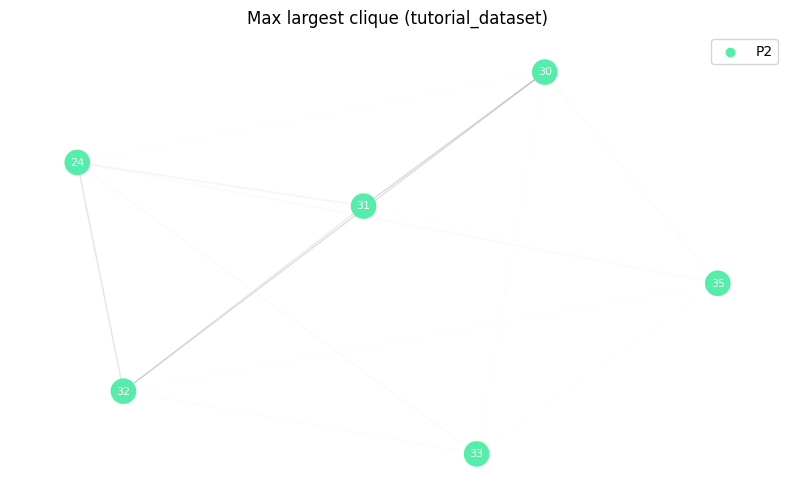

<Figure size 640x480 with 0 Axes>

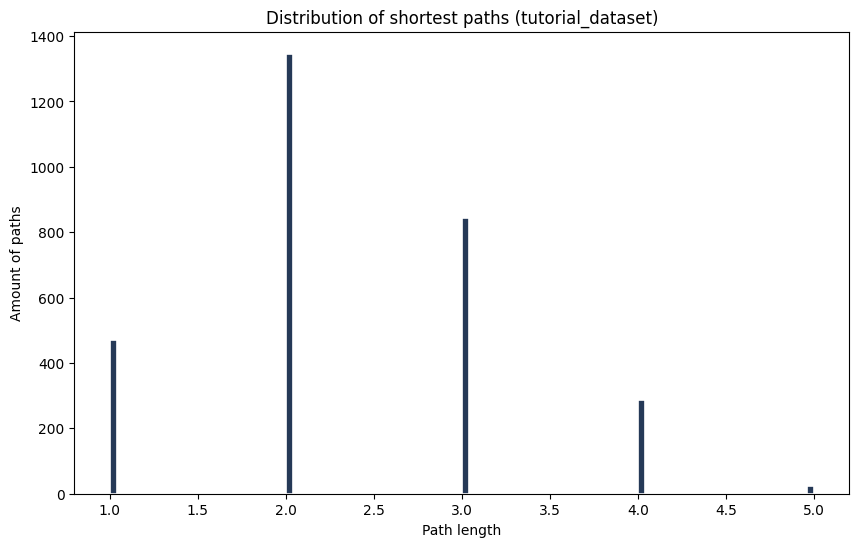

<Figure size 640x480 with 0 Axes>

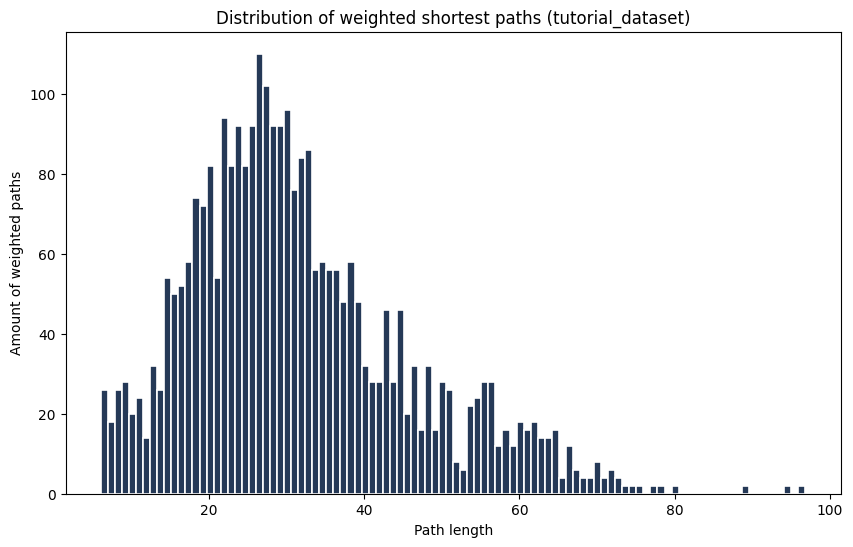

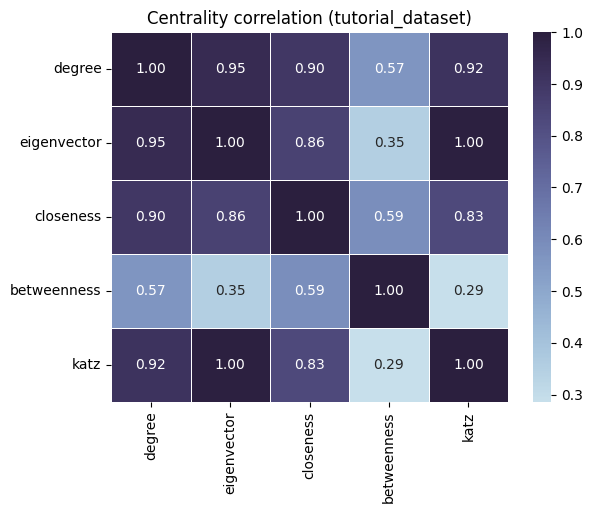

<Figure size 640x480 with 0 Axes>

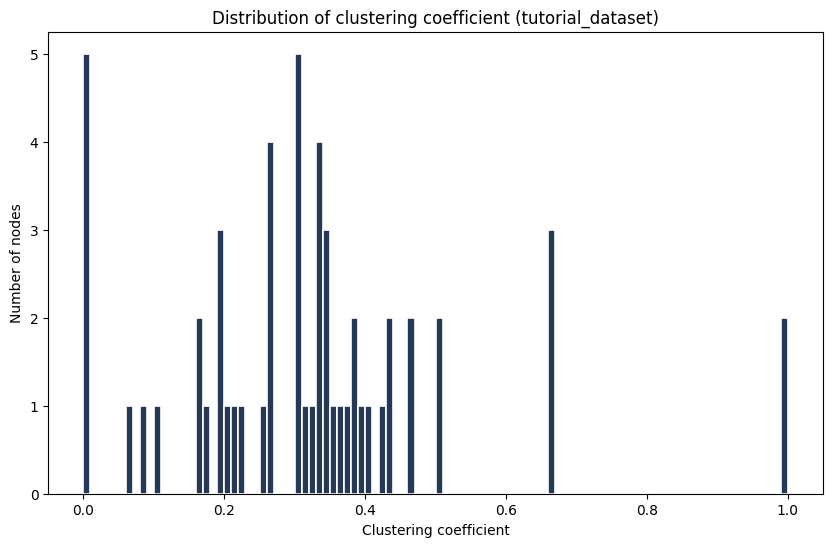

<Figure size 640x480 with 0 Axes>

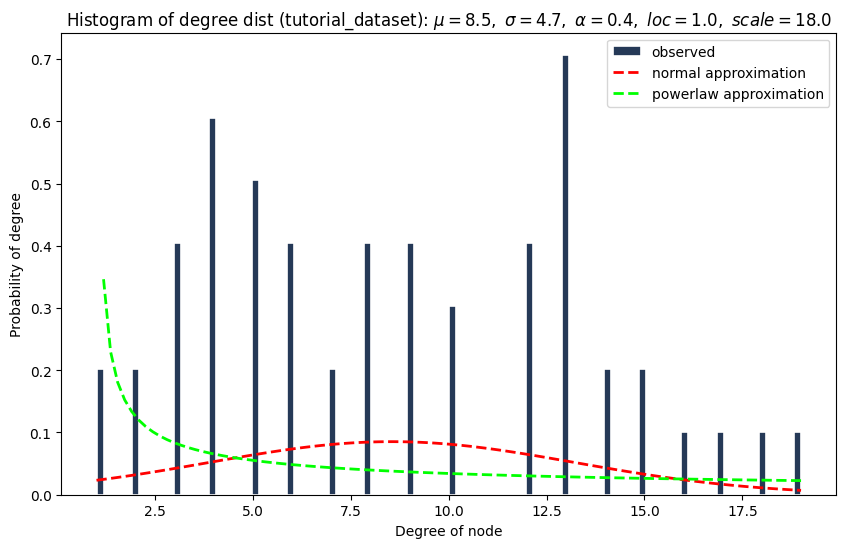

/disk/10tb/home/shmelev/GENLINK/utils/genlink.py:940: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([],[], c=v, label=k)


<Figure size 640x480 with 0 Axes>

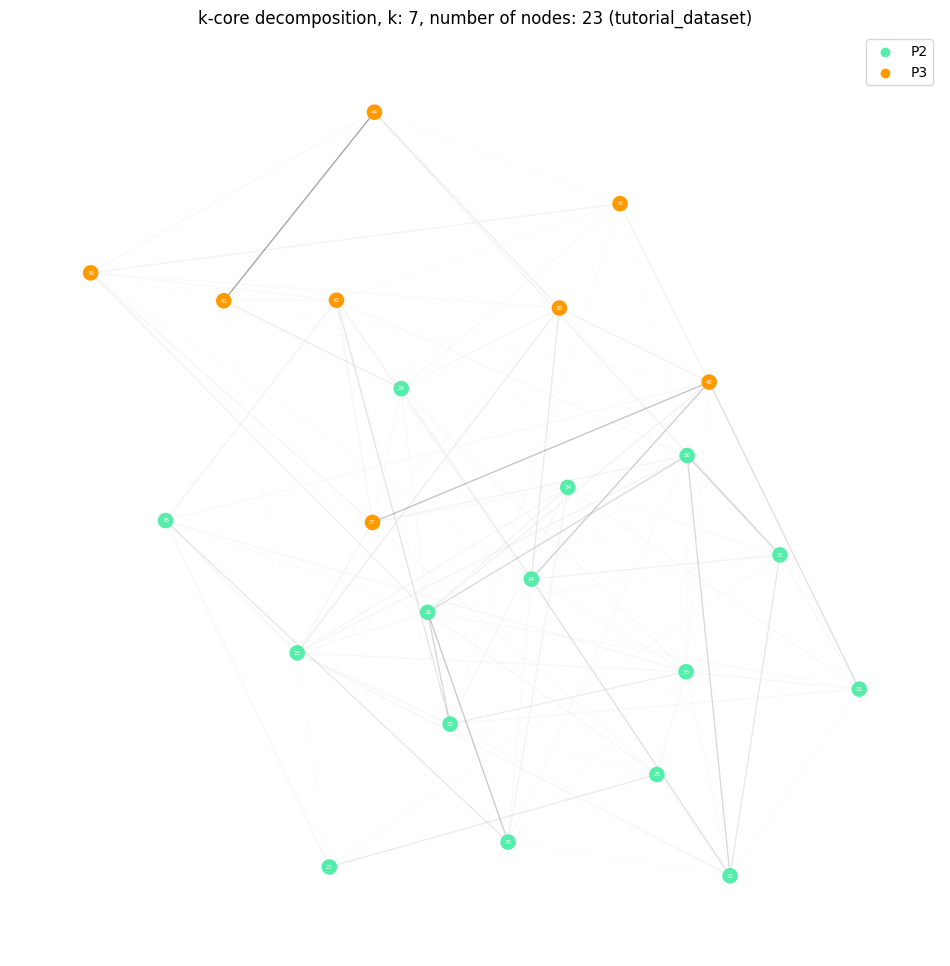

<Figure size 640x480 with 0 Axes>

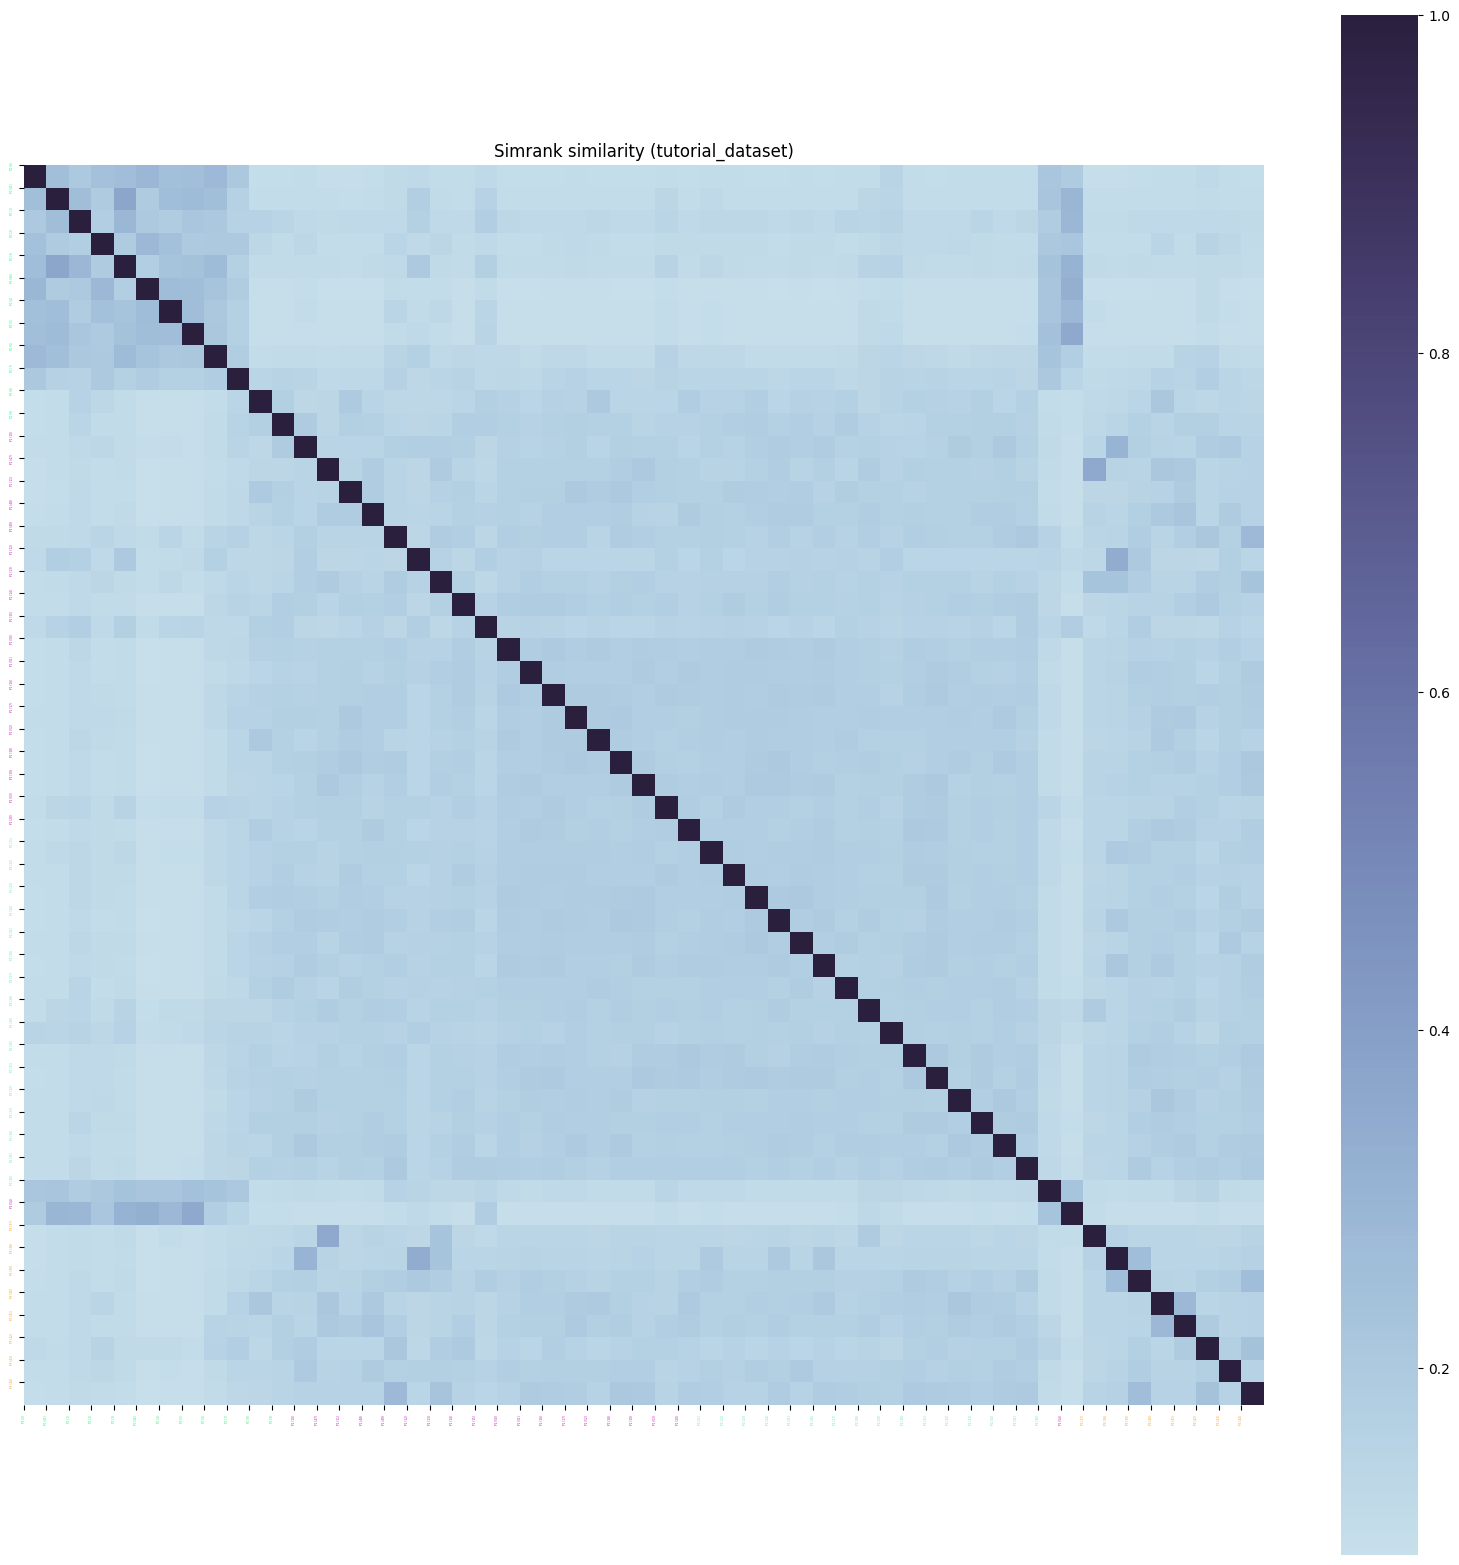

<Figure size 640x480 with 0 Axes>

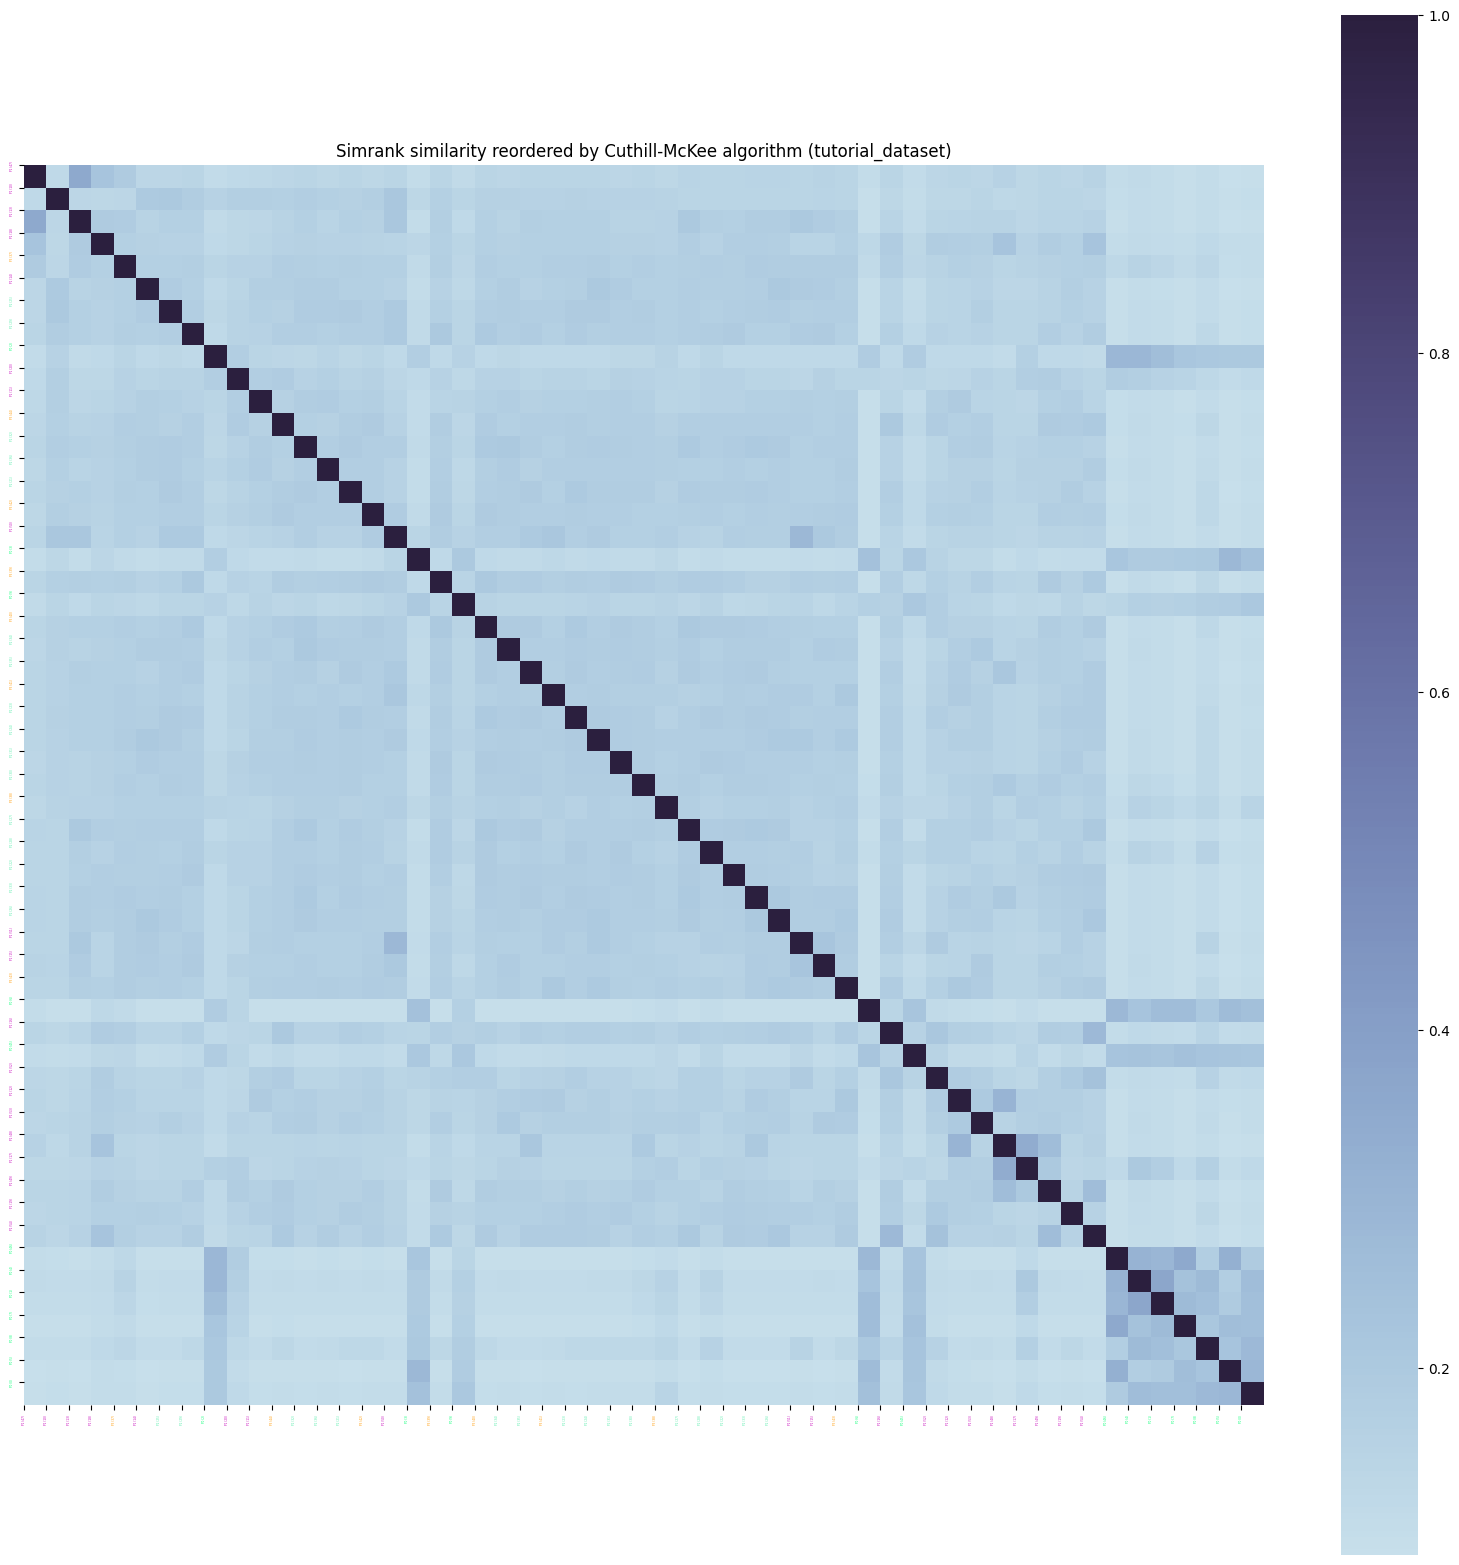

In [22]:
features = dp.get_graph_features(fig_path=f'{os.environ.get("HOME")}/GENLINK/data/tutorial', 
                                 fig_size=(10, 6), 
                                 dataset_name='tutorial_dataset')

You can see whole bunch of other different parameters in the returned dictionary. See documantation of `networkx` library to find defenitions

In [23]:
features

{'Number of nodes': 55,
 'Number of edges': 235,
 'Density': 0.15824915824915825,
 'Self-loop edges': [],
 'Is connected': True,
 'Number of cc': 1,
 'Number of isolated nodes': 0,
 'Is planar': False,
 'Diameter': 5,
 'Radius': 3,
 'Transitivity': 0.3195789473684211,
 'Number of multi edges': 0,
 'Max degree': 19,
 'Mean degree': 8.545454545454545,
 'Min degree': 1,
 'Global efficiency': 0.5052637485970799,
 'Local efficiency': 0.48875404834347974,
 'Degree assortativity coefficient': 0.2559544578969743,
 'Class assortativity coefficient': 0.3653266853640803,
 'Average clustering': 0.32223176251462204,
 'Center': [9, 18, 20, 30, 37],
 'Periphery': [0, 46, 5, 7, 47, 48, 49, 13, 14, 15, 22, 54],
 'Is Eulerian': False,
 'Is semi-Eulerian': False,
 'Is regular': False,
 'Average shortest path length': 2.342760942760943,
 'Weighted average shortest path length': 31.67957687659728,
 'Is tree': False,
 'Is forest': False,
 'global_clustering_coefficient': 0.6391578947368421,
 'Max degree cen

# Create train/valid/test graphs

In order to train our GNN, we firstly need to specify which nodes we will construct train/valid/test graphs from. You can do it simply by calling `generate_random_train_valid_test_nodes` function with the following parameters (equal class balance of node classes in train/valid/test nodes was already considered):

* `train_size` - percent of nodes for training
* `valid_size` - pervent of node for validation
* `test_size` - percent of node for testing
* `random_state` - seed
* `save_dir` - node splits can be saved to file
* `mask_size` - percent of artificially masked nodes (can be from `0.0` to `1.0`), used only for artificial masking tests
* `sub_train_size` - percent from TRAIN nodes (regulated with `train_size`), remained TRAIN nodes will be used for masking (regulated with `mask_size`), can be from `0.0` to `1.0` but setting it to `1.0` is useless, used only for artificial masking tests
* `keep_train_nodes` - `True` if we want to make nodes, controlled by `sub_train_size`, to be the same across different random seeds, used only for artificial masking tests
* `mask_random_state` - controls which nodes will be considered masked (controlled by `mask_size`), used only for artificial masking tests

In [24]:
# now we're runnsing simple tests without artificial masking, so we can omit most of the parameters
dp.generate_random_train_valid_test_nodes(train_size=0.6,
                                          valid_size=0.2, 
                                          test_size=0.2, 
                                          random_state=seed,
                                          save_dir=None,
                                          mask_size=None,
                                          sub_train_size=None,
                                          keep_train_nodes=None,
                                          mask_random_state=None)

100.0% (55) of all nodes in dataset were used to create splits (no masked nodes assumed)


You can directly access tarin/valid/test split like this

In [25]:
# you can convert those node names to real node names like that were shown above
print(f'Train nodes: {np.array(dp.train_nodes)}')
print(f'Valid nodes: {np.array(dp.valid_nodes)}')
print(f'Test nodes: {np.array(dp.test_nodes)}')
print(f'Masked nodes: {np.array(dp.mask_nodes)}')

Train nodes: [31  5 32 13 19 49 41 26 43 12 52  3 33 34  8 17  6  4 47 27 46 45 53 15
  9 16 24 30 37 25 11 48 36 40 39]
Valid nodes: [ 0 29  1 21 50 35 44 10 18 54 42]
Test nodes: [ 2 23 22 20  7 14 28 51 38]
Masked nodes: None


You can also load your own splits (for the tutorial purpose we will create a copy of `DataProcessor` object and make further modifications there). Just call the function `load_partitions` with the following arguments:

* `train_socket` - python list with ORIGINAL names of nodes for training
* `valid_socket` - python list with ORIGINAL names of nodes for validation
* `test_socket` - python list with ORIGINAL names of nodes for testing
* `mask_socket` - python list with ORIGINAL names of masked nodes (optional)

In [26]:
dpc = deepcopy(dp)
dpc.load_partitions(train_socket=['node_1', 'node_10', 'node_12', 'node_22', 'node_14'],
                    valid_socket=['node_9', 'node_50', 'node_8'],
                    test_socket=['node_39', 'node_18'],
                    mask_socket=None)

print(f'Train nodes: {np.array(dpc.train_nodes)}')
print(f'Valid nodes: {np.array(dpc.valid_nodes)}')
print(f'Test nodes: {np.array(dpc.test_nodes)}')

Train nodes: [ 0  8 52 13 50]
Valid nodes: [ 7 39  6]
Test nodes: [28 51]


But we've generated only node split, not graphs. In order to generate graphs you can call function `make_train_valid_test_datasets_with_numba` with the following parameters:

* `feature_type` - strictly `one_hot` or `graph_based`, defines type of method for node features generation
* `model_type` - for now it should be always `homogeneous`
* `train_dataset_type` - strictly `multiple` for `one_hot` type of features (argument `feature_type`) and `one` for `graph_based` type of features
* `test_dataset_type` - always `multiple`
* `log_edge_weights` - in case you want genetically normalised edge weights
* `skip_train_val` - create graphs only for testing (skip creation of training and validation graphs)
* `masking` - must be `True` if you want to run experiments with any type of masking, otherwise `False`
* `no_mask_class_in_df` - must be `True` if initial `.csv` file does not contain masked nodes, otherwise `False`
* `make_ram_efficient_dataset` - set `True` (slower but RAM efficient) if you want to same RAM on CPU (not GPU) on you machine, otherwise `False` (faster but uses more RAM)

In [27]:
dp.make_train_valid_test_datasets_with_numba(feature_type='one_hot', 
                                             model_type='homogeneous', 
                                             train_dataset_type='multiple', 
                                             test_dataset_type='multiple',
                                             log_edge_weights=False,
                                             skip_train_val=False,
                                             masking=False,
                                             no_mask_class_in_df=True,
                                             make_ram_efficient_dataset=False)

Make test samples: 100%|██████████| 9/9 [00:00<00:00, 447.58it/s]


You can directly access generated graphs like that

In [28]:
print(dp.array_of_graphs_for_training) # you have multiple training graphs for one_hot node features and only one trainign graph for "graph_based" features
print(dp.array_of_graphs_for_validation)
print(dp.array_of_graphs_for_testing)

[Data(x=[35, 4], edge_index=[2, 184], y=[35], weight=[184], mask=[35], correct_and_smooth_mask=[35], num_classes=4), Data(x=[35, 4], edge_index=[2, 184], y=[35], weight=[184], mask=[35], correct_and_smooth_mask=[35], num_classes=4), Data(x=[35, 4], edge_index=[2, 184], y=[35], weight=[184], mask=[35], correct_and_smooth_mask=[35], num_classes=4), Data(x=[35, 4], edge_index=[2, 184], y=[35], weight=[184], mask=[35], correct_and_smooth_mask=[35], num_classes=4), Data(x=[35, 4], edge_index=[2, 184], y=[35], weight=[184], mask=[35], correct_and_smooth_mask=[35], num_classes=4), Data(x=[35, 4], edge_index=[2, 184], y=[35], weight=[184], mask=[35], correct_and_smooth_mask=[35], num_classes=4), Data(x=[35, 4], edge_index=[2, 184], y=[35], weight=[184], mask=[35], correct_and_smooth_mask=[35], num_classes=4), Data(x=[35, 4], edge_index=[2, 184], y=[35], weight=[184], mask=[35], correct_and_smooth_mask=[35], num_classes=4), Data(x=[35, 4], edge_index=[2, 184], y=[35], weight=[184], mask=[35], c

You can see that those graphs are not in `networkx` format but in `Data` object of `pytorch_geometric`. You can convert that object back to `networkx` format like that

In [29]:
from torch_geometric.utils import to_networkx
some_train_graph_nx = to_networkx(dp.array_of_graphs_for_training[0], edge_attrs=['weight'], node_attrs=['y', 'mask'], to_undirected=True)
some_train_graph_nx

You can also check that this graph was constructed correctly. Use very powerful function `vf2pp_is_isomorphic` for that (it provides the most accurate isomorphism check)

In [30]:
import networkx as nx
nx.vf2pp_is_isomorphic(nx.subgraph(dp.nx_graph, dp.train_nodes), some_train_graph_nx)

True

You can check all train/validation/test graphs as well

In [31]:
# checking train graphs

for i in range(len(dp.array_of_graphs_for_training)):
    nx.vf2pp_is_isomorphic(nx.subgraph(dp.nx_graph, dp.train_nodes), 
                           to_networkx(dp.array_of_graphs_for_training[i], edge_attrs=['weight'], node_attrs=['y', 'mask'], to_undirected=True))

# checking validation graphs

for i, node in enumerate(dp.valid_nodes):
    rg = nx.subgraph(dp.nx_graph, dp.train_nodes + [node])
    mg = to_networkx(dp.array_of_graphs_for_validation[i], edge_attrs=['weight'], node_attrs=['y', 'mask'], to_undirected=True)
    assert nx.vf2pp_is_isomorphic(rg, mg)

# checking test graphs

for i, node in enumerate(dp.test_nodes):
    rg = nx.subgraph(dp.nx_graph, dp.train_nodes + [node])
    mg = to_networkx(dp.array_of_graphs_for_testing[i], edge_attrs=['weight'], node_attrs=['y', 'mask'], to_undirected=True)
    assert nx.vf2pp_is_isomorphic(rg, mg)

# Training

In order to run appropriate training, you need only one class `Trainer` that does everything for you. Pay attantion to all its arguments:

* `data` - your `DataProcessor` object
* `model_cls` - class of your GNN
* `lr` - desired learning rate
* `wd` - desired weight decay
* `loss_fn` - class of loss function
* `batch_size` - all your generated graphs are loaded on GPU not one by one, this parameters regulates how many graph will be loaded to CPU during single iteration, this parameter does not afect training on CPU
* `log_dir` - metrics will be saved here after training
* `patience` - how long should we wait till the training stop if metrics in validation garphs do not increase
* `num_epochs` - should be (int) for `one_hot` node features and `None` for `graph_based` features, it represents the number of epochs for training only on graphs with `one_hot` node features
* `feature_type` - strictly `one_hot` or `graph_based`, defines type of method for node features generation
* `train_iterations_per_sample` - shuld be (int) for `graph_based` node features and `None` for `one_hot` features, it represents the number of iteration for training only on graphs with `graph_based` node features
* `evaluation_steps` - should be (int), representing after what amount of iterations you should run validation each time
* `weight` - loss weights, should be torch tensor with the same amount of elements as the amount of you populations
* `masking` - must be `True` if you use training with masked nodes, otherwise `False`
* `cuda_device_specified` - you can specify CUDA device ID that well be used for trainign network (int)
* `disable_printing` - should be `True` if you want to supress almost all logs, otherwise `False`
* `seed` - seed
* `save_model_in_ram` - `True` if you want to save you model in RAM after training is finished and the best model is obtained, otherwise `False`
* `correct_and_smooth` - `True` if you want to combine GNN with Label Propagation, otherwise `False` (we recommend always keep it `False`)
* `no_mask_class_in_df` - must be `True` if initial `.csv` file does not contain masked nodes, otherwise `False`
* `remove_saved_model_after_testing` - during training your intermediate checkpoint of the model is saved in you `log_dir`, if `True`, the best checkpoint will be deleted after training, if `False` the best checkpoint will be retained
* `plot_cm` - you can plot confusion matric on test graphs after training (set it as `True` then)
* `use_class_balance_weight` - use loss weights according to representation of each class (great for imbalances datasets)
* `num_workers` - how many workers to use in DataLoader (int)

In [32]:
import torch
trainer = Trainer(data=dp,
        model_cls=GL_TAGConv_3l_512h_w_k3_gnorm, 
        lr=0.0001, 
        wd=0.0001, 
        loss_fn=torch.nn.CrossEntropyLoss, 
        batch_size=10, 
        log_dir=f'{os.environ.get("HOME")}/GENLINK/data/tutorial', 
        patience=10, 
        num_epochs=10, 
        feature_type='one_hot', 
        train_iterations_per_sample=None, 
        evaluation_steps=None, 
        weight=[None],
        masking=False, 
        cuda_device_specified=0,
        disable_printing=False,
        seed=seed, 
        save_model_in_ram=True, 
        correct_and_smooth=False, 
        no_mask_class_in_df=True,
        remove_saved_model_after_testing=False,
        plot_cm=True,
        use_class_balance_weight=True,
        num_workers=2)

Using loss weights according to class balance


Now run and you're done!

Training for data: tutorial_dataset


Training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Compute metrics: 100%|██████████| 11/11 [00:01<00:00,  6.24it/s]


Evaluation report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         4
           2       0.29      0.67      0.40         3
           3       0.00      0.00      0.00         2

    accuracy                           0.18        11
   macro avg       0.07      0.17      0.10        11
weighted avg       0.08      0.18      0.11        11

f1 macro score on valid dataset for class 0 which is P0: 0.0
f1 macro score on valid dataset for class 1 which is P1: 0.0
f1 macro score on valid dataset for class 2 which is P2: 0.4
f1 macro score on valid dataset for class 3 which is P3: 0.0
f1 macro improvement to 0.1


Training epochs:  10%|█         | 1/10 [00:02<00:20,  2.25s/it]

Mean loss: 0.5113294124603271




Compute metrics: 100%|██████████| 11/11 [00:00<00:00, 45.61it/s]


Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      0.67      0.80         3
           3       0.67      1.00      0.80         2

    accuracy                           0.91        11
   macro avg       0.92      0.92      0.90        11
weighted avg       0.94      0.91      0.91        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 1.0
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.8
f1 macro improvement to 0.8999999999999999



Training samples: 100%|██████████| 35/35 [00:00<00:00, 47.01it/s, val_best_score=0.1] 




Training epochs:  20%|██        | 2/10 [00:03<00:11,  1.38s/it]

Mean loss: 0.20872488617897034


Compute metrics: 100%|██████████| 11/11 [00:00<00:00, 45.69it/s]


Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.50      0.67         4
           2       1.00      0.67      0.80         3
           3       0.40      1.00      0.57         2

    accuracy                           0.73        11
   macro avg       0.85      0.79      0.76        11
weighted avg       0.89      0.73      0.75        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 0.6666666666666666
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.5714285714285714
Metric was not improved for the 1th time


Training epochs:  30%|███       | 3/10 [00:03<00:07,  1.08s/it]

Mean loss: 0.1392304003238678




Compute metrics: 100%|██████████| 11/11 [00:00<00:00, 44.59it/s]


Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.75      0.86         4
           2       1.00      0.67      0.80         3
           3       0.50      1.00      0.67         2

    accuracy                           0.82        11
   macro avg       0.88      0.85      0.83        11
weighted avg       0.91      0.82      0.83        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 0.8571428571428571
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.6666666666666666
Metric was not improved for the 2th time



Training samples: 100%|██████████| 35/35 [00:00<00:00, 48.18it/s, val_best_score=0.9] 




Training epochs:  40%|████      | 4/10 [00:04<00:05,  1.06it/s]

Mean loss: 0.07811927795410156


Compute metrics: 100%|██████████| 11/11 [00:00<00:00, 44.08it/s]


Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      0.67      0.80         3
           3       0.67      1.00      0.80         2

    accuracy                           0.91        11
   macro avg       0.92      0.92      0.90        11
weighted avg       0.94      0.91      0.91        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 1.0
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.8
Metric was not improved for the 3th time


Training epochs:  50%|█████     | 5/10 [00:05<00:04,  1.15it/s]

Mean loss: 0.04409902170300484




Compute metrics: 100%|██████████| 11/11 [00:00<00:00, 44.96it/s]


Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      0.67      0.80         3
           3       0.67      1.00      0.80         2

    accuracy                           0.91        11
   macro avg       0.92      0.92      0.90        11
weighted avg       0.94      0.91      0.91        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 1.0
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.8
Metric was not improved for the 4th time



Training samples: 100%|██████████| 35/35 [00:00<00:00, 46.90it/s, val_best_score=0.9]




Training epochs:  60%|██████    | 6/10 [00:05<00:03,  1.21it/s]

Mean loss: 0.03401627764105797


Compute metrics: 100%|██████████| 11/11 [00:00<00:00, 44.83it/s]


Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.50      0.67         4
           2       1.00      0.67      0.80         3
           3       0.40      1.00      0.57         2

    accuracy                           0.73        11
   macro avg       0.85      0.79      0.76        11
weighted avg       0.89      0.73      0.75        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 0.6666666666666666
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.5714285714285714
Metric was not improved for the 5th time


Training epochs:  70%|███████   | 7/10 [00:06<00:02,  1.25it/s]

Mean loss: 0.04453390836715698




Compute metrics: 100%|██████████| 11/11 [00:00<00:00, 36.97it/s]


Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      0.67      0.80         3
           3       0.67      1.00      0.80         2

    accuracy                           0.91        11
   macro avg       0.92      0.92      0.90        11
weighted avg       0.94      0.91      0.91        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 1.0
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.8
Metric was not improved for the 6th time



Training samples: 100%|██████████| 35/35 [00:00<00:00, 44.36it/s, val_best_score=0.9] 




Training epochs:  80%|████████  | 8/10 [00:07<00:01,  1.25it/s]

Mean loss: 0.04188750311732292


Compute metrics: 100%|██████████| 11/11 [00:00<00:00, 39.10it/s]


Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.75      0.86         4
           2       0.67      0.67      0.67         3
           3       0.33      0.50      0.40         2

    accuracy                           0.73        11
   macro avg       0.75      0.73      0.73        11
weighted avg       0.79      0.73      0.75        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 0.8571428571428571
f1 macro score on valid dataset for class 2 which is P2: 0.6666666666666666
f1 macro score on valid dataset for class 3 which is P3: 0.4
Metric was not improved for the 7th time


Training epochs:  90%|█████████ | 9/10 [00:08<00:00,  1.25it/s]

Mean loss: 0.08866852521896362




Compute metrics: 100%|██████████| 11/11 [00:00<00:00, 45.61it/s]


Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      0.67      0.80         3
           3       0.67      1.00      0.80         2

    accuracy                           0.91        11
   macro avg       0.92      0.92      0.90        11
weighted avg       0.94      0.91      0.91        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 1.0
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.8
Metric was not improved for the 8th time



Training samples: 100%|██████████| 35/35 [00:00<00:00, 45.11it/s, val_best_score=0.9]




Training epochs: 100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


Mean loss: 0.02067103609442711


Compute metrics: 100%|██████████| 9/9 [00:00<00:00, 39.50it/s]
/disk/10tb/home/shmelev/miniconda3/envs/genlink/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/disk/10tb/home/shmelev/miniconda3/envs/genlink/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/disk/10tb/home/shmelev/miniconda3/envs/genlink/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze

Test report
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         1

    accuracy                           0.89         9
   macro avg       0.67      0.75      0.70         9
weighted avg       0.81      0.89      0.84         9

f1 macro score on test dataset: 0.7
f1 weighted score on test dataset: 0.8444444444444444
recall macro score on test dataset: 0.75
recall weighted score on test dataset: 0.8888888888888888
recall macro score on test dataset: 0.6666666666666666
recall weighted score on test dataset: 0.8148148148148148
accuracy score on test dataset: 0.8888888888888888
f1 macro score on test dataset for class 0 which is P0: 0.8
f1 macro score on test dataset for class 1 which is P1: 1.0
f1 macro score on test dataset for class 2 which is P2: 1.0
f1 macro score on te

Training samples: 100%|██████████| 35/35 [00:00<00:00, 36.64it/s, val_best_score=0.9]


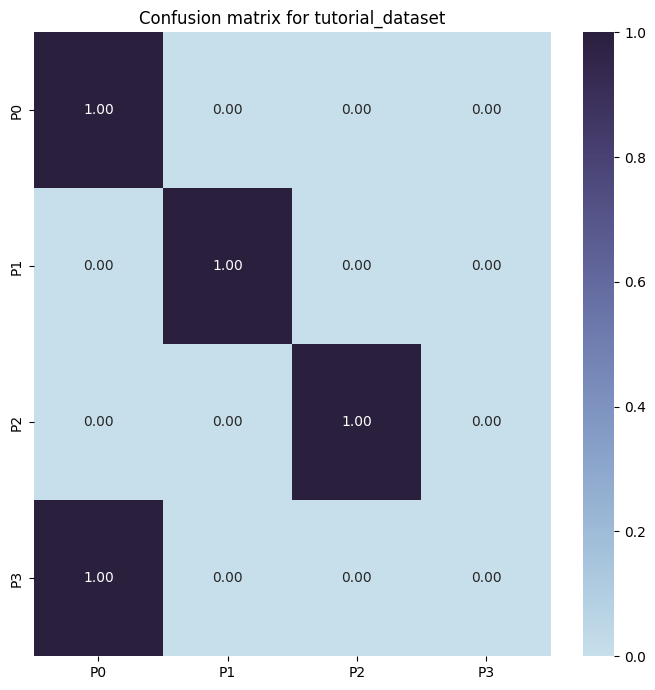

In [33]:
results = trainer.run()

In [34]:
# this variable will store all obtained metrics
# skipped_nodes - number of test nodes that became isolated during train/val/test split
# class_scores - f1 score per class
results

{'f1_macro': 0.7,
 'f1_weighted': 0.8444444444444444,
 'precision_macro': 0.6666666666666666,
 'precision_weighted': 0.8148148148148148,
 'recall_macro': 0.75,
 'recall_weighted': 0.8888888888888888,
 'accuracy': 0.8888888888888888,
 'class_scores': {'P0': 0.8, 'P1': 1.0, 'P2': 1.0, 'P3': 0.0},
 'skipped_nodes': 0,
 'memory_allocated_MB': 36.6865234375,
 'memory_reserved_MB': 46.0}

In order to visualise predictions of the model, simply call the function `visualize_predictions` with the following parameters:

* `model` - your trained model
* `test_graph` - the graph in `Data` object format that you want to visualise
* `test_node` - relabeled node name (see code cell below to understand how to get it)
* `base_node_size` - size of nodes
* `selected_node_size` - size of specified node
* `node_labels` - can be `None` if you don't want to plot node labels, `"dataset"` if you want to plot relabeled node names, `"real"` if you want to plot real node names
* `node_labels_size` - size of node labels
* `node_label_font_color` - color of nodel labels
* `use_component` - `True` if you want to visualise the whole component of the graph with test node, `False` otherwise (will be visualised only neighbours of the test node)

In [35]:
the_graph_i_want_to_see = 8
print(f'Current test node: {dp.test_nodes[the_graph_i_want_to_see]}, assign this values to test_node variable below')

Current test node: 38, assign this values to test_node variable below


Number of initial nodes: 36
Number of final nodes: 13


/disk/10tb/home/shmelev/GENLINK/utils/genlink.py:1902: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter([],[], c=clr, label=f'{self.class_to_int_mapping[i]}')
/disk/10tb/home/shmelev/GENLINK/utils/genlink.py:1903: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter([],[], c=clr, label=f'{self.class_to_int_mapping[i]}')


<Figure size 640x480 with 0 Axes>

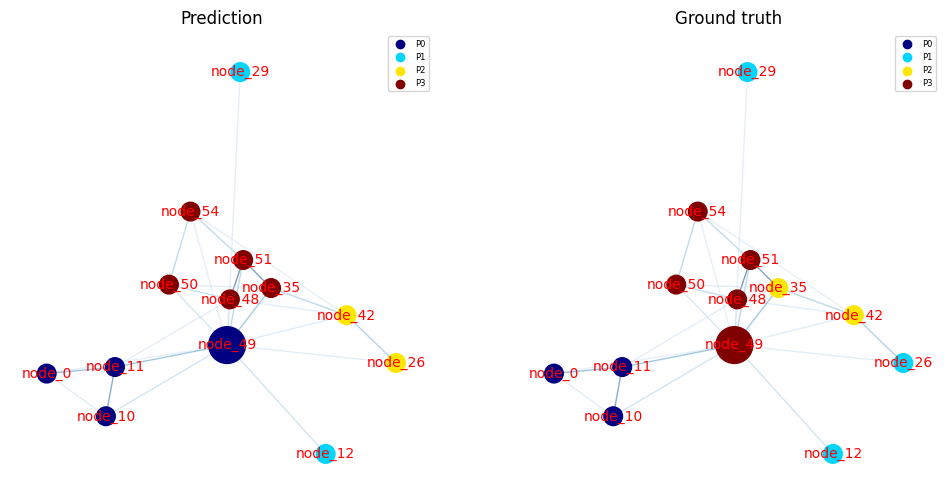

In [36]:
dp.visualize_predictions(model=trainer.model,
                         test_graph=dp.array_of_graphs_for_testing[the_graph_i_want_to_see],
                         test_node=38, # we get this from previous code cell
                         node_labels_size=10, 
                         node_label_font_color='red',
                         node_labels='real',
                         base_node_size=180,
                         selected_node_size=700,
                         use_component=False)

# Prediction on custom graphs

Now we know how to train, validate and test our model, visualise predictions and compute graph parameters. But we were working with predefined full graph. What if we want to validate our trained model on a completely new graph that was not presented in initial graph by any chance? Firstly, let's create such a new graph by adding node "node_test" (you can use whatever node name you want) and connect it to some nodes from the **training graph**

In [37]:
# here is how you can get processed dataframe
dp.df

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n
0,0,45,0,0,79.181347,1
1,1,45,0,0,9.701131,1
2,2,45,0,0,28.309291,1
3,3,45,0,0,14.826807,1
4,3,1,0,0,11.424783,1
...,...,...,...,...,...,...
230,44,36,3,2,6.396516,1
231,44,38,3,3,46.897711,1
232,44,39,3,3,25.709908,1
233,44,41,3,3,156.257226,1


In [38]:
# here is our originally simulated dataset
df_init = pd.read_csv(graph_file_path)
df_init

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n
0,node_1,node_0,P0,P0,79.181347,1
1,node_2,node_0,P0,P0,9.701131,1
2,node_4,node_0,P0,P0,28.309291,1
3,node_5,node_0,P0,P0,14.826807,1
4,node_5,node_2,P0,P0,11.424783,1
...,...,...,...,...,...,...
230,node_55,node_47,P3,P2,6.396516,1
231,node_55,node_49,P3,P3,46.897711,1
232,node_55,node_50,P3,P3,25.709908,1
233,node_55,node_52,P3,P3,156.257226,1


Let's add edges between "node_test" and "node_5", "node_6", "node_7", "node_50". But before doing this we need to check were those nodes in train graph

In [39]:
df_init.iloc[[6, 7, 8, 9, 232]]

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n
6,node_5,node_4,P0,P0,47.332943,1
7,node_6,node_0,P0,P0,35.709737,1
8,node_6,node_5,P0,P0,37.841436,1
9,node_7,node_2,P0,P0,46.932892,1
232,node_55,node_50,P3,P3,25.709908,1


In [40]:
for node in ['node_5', 'node_6', 'node_7', 'node_50']:
    assert dp.node_names_to_int_mapping[node] in dp.train_nodes

In [41]:
# here we create new sub dataframe with new node "node_test", you MUST assign whatever class to such nodes (prediction will not depend on it because it will be a test node),
# those classes MUST be from existing one in dataset
df_add = pd.DataFrame({'node_id1':['node_test', 'node_test', 'node_test', 'node_50'], 
                       'node_id2':['node_5', 'node_6', 'node_7', 'node_test'], 
                       'label_id1':['P1', 'P1', 'P1', 'P3'], # let's assign P1 as "fake ground truth" class for our node_test
                       'label_id2':['P0', 'P0', 'P0', 'P1'], # let's assign P1 as "fake ground truth" class for our node_test
                       'ibd_sum':[10.0, 10.0, 10.0, 10.0], # we use arbitrary values here just as example
                       'ibd_n':[1, 1, 1, 1]})
df_add

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n
0,node_test,node_5,P1,P0,10.0,1
1,node_test,node_6,P1,P0,10.0,1
2,node_test,node_7,P1,P0,10.0,1
3,node_50,node_test,P3,P1,10.0,1


In [42]:
# now we merge all those dataframes
df_mod = pd.concat([df_init, df_add], axis=0)
df_mod = df_mod.reset_index(drop=True)
df_mod

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n
0,node_1,node_0,P0,P0,79.181347,1
1,node_2,node_0,P0,P0,9.701131,1
2,node_4,node_0,P0,P0,28.309291,1
3,node_5,node_0,P0,P0,14.826807,1
4,node_5,node_2,P0,P0,11.424783,1
...,...,...,...,...,...,...
234,node_55,node_54,P3,P3,15.175590,1
235,node_test,node_5,P1,P0,10.000000,1
236,node_test,node_6,P1,P0,10.000000,1
237,node_test,node_7,P1,P0,10.000000,1


In [43]:
# now we need to create new DataProcessor object using megred dataframe
dpm = DataProcessor(path=df_mod,
                    is_path_object=True,
                    disable_printing=False,
                    dataset_name='new_node_dataset',
                    no_mask_class_in_df=True)

Good. Now we need to construct graph using `Data` object. It can be done using the same functions that we discussed before

In [44]:
# Firstly, we need to load train and test nodes in our new DataProcessor object (dpm), we don't set up masked nodes here
# However, if you have real masked nodes, you can load them in mask_socket as well
# By using the same logic you can set up multiple new nodes (like node_test), they will be evaluated independently
dpm.load_partitions(train_socket=[dp.int_to_node_names_mapping[node] for node in dp.train_nodes],
                    valid_socket=[], # be carefull with that, do not use empty array of valid nodes during normal training
                    test_socket=['node_test'])

In [45]:
# making graphs in Data object, as usually but setting skip_train_val to True
dpm.make_train_valid_test_datasets_with_numba(feature_type='one_hot', 
                                             model_type='homogeneous', 
                                             train_dataset_type='multiple', 
                                             test_dataset_type='multiple',
                                             log_edge_weights=False,
                                             skip_train_val=True, # keep it in mind
                                             masking=False,
                                             no_mask_class_in_df=True,
                                             make_ram_efficient_dataset=False)

Make test samples: 100%|██████████| 1/1 [00:00<00:00, 351.99it/s]


In [46]:
# you can get masks for loss the following way (now they are always True becase we don't have unlabeled nodes in dataset)
dpm.array_of_graphs_for_testing[0].mask

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True])

In [47]:
# you can check that there is no data leak, namely features of node_test are uniformly distributed
dpm.array_of_graphs_for_testing[0].x # look at the last row, it is features of node_test and they don't contain one-hot encoded class

tensor([[0.0000, 0.0000, 1.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0

In [48]:
# yeah, in targets you have that "fake class" for our node_test (see last digit) but it won't be used by the model because we marked it as a test node before
dpm.array_of_graphs_for_testing[0].y

tensor([2, 0, 2, 1, 1, 1, 3, 2, 3, 1, 1, 0, 2, 2, 0, 1, 0, 0, 1, 2, 0, 0, 1, 1,
        0, 1, 2, 2, 3, 2, 1, 1, 2, 3, 3, 1])

In [49]:
# make sure the core of the graph (that should consist only from the train nodes) is the same as in dp object (not dpm object)

dpm_test_graph = to_networkx(dpm.array_of_graphs_for_testing[0], edge_attrs=['weight'], node_attrs=['y', 'mask'], to_undirected=True)
dp_train_graph = to_networkx(dp.array_of_graphs_for_training[0], edge_attrs=['weight'], node_attrs=['y', 'mask'], to_undirected=True)

dpm_test_graph_core = nx.subgraph(dpm_test_graph, list(range(len(dpm_test_graph.nodes) - 1))) # we can do this because validation and test nodes always have the last idx in graph, so we just substract 1

assert nx.vf2pp_is_isomorphic(dp_train_graph, dpm_test_graph_core)

Time to get prediction for each our new test nodes independently (in our case number of nodes is 1)!!! Set up new Trainer with the same parameters but with different DataProcessor object

In [50]:
trainer_test = Trainer(data=dpm, # pay attention here
        model_cls=GL_TAGConv_3l_512h_w_k3_gnorm, # same model class is crucial
        lr=0.0001, 
        wd=0.0001, 
        loss_fn=torch.nn.CrossEntropyLoss, 
        batch_size=10, 
        log_dir=f'{os.environ.get("HOME")}/GENLINK/data/tutorial', 
        patience=10, 
        num_epochs=10, 
        feature_type='one_hot', 
        train_iterations_per_sample=None, 
        evaluation_steps=None, 
        weight=[None],
        masking=False, 
        cuda_device_specified=0,
        disable_printing=False,
        seed=seed, 
        save_model_in_ram=True, 
        correct_and_smooth=False, 
        no_mask_class_in_df=True,
        remove_saved_model_after_testing=False,
        plot_cm=True,
        use_class_balance_weight=True,
        num_workers=2)

Using loss weights according to class balance


And now we need to call `load_model_and_get_predictions` function with a single argument:

* `path` - path to the checkpoin of the model

In [51]:
answers = trainer_test.load_model_and_get_predictions(path=f'{os.environ.get("HOME")}/GENLINK/data/tutorial/model_best.bin')

As the result, you get the dictionary with keys as your test graphs id and values as another dictionary with the following attributes:

* `answer_class` - prediction in readable format (your actual classes)
* `answer_id` - prediction in relabeled classes
* `probabilities` - class probabilities

In [52]:
answers

{'test_graph_0': {'answer_class': 'P0',
  'answer_id': 0,
  'probabilities': array([9.9984443e-01, 3.3963592e-05, 5.0355269e-05, 7.1311530e-05],
        dtype=float32)}}

# Training and validation on graphs with masks

You may have noticed that there were no unlabeled (masked) nodes at all before. Let's add them to the graph and see how to train and validate model with them. Firstly, we need to create new dataframe with masked nodes that we want to add to our "tutorial graph". For example, let's attach one masked node to one tarin node for each class (so we add 4 masked nodes to our initial graph in total)

In [53]:
df_init.iloc[[6, 30, 58, 232]]

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n
6,node_5,node_4,P0,P0,47.332943,1
30,node_20,node_19,P1,P1,33.471126,1
58,node_35,node_32,P2,P2,11.854273,1
232,node_55,node_50,P3,P3,25.709908,1


In [54]:
for node in ['node_5', 'node_19', 'node_35', 'node_50']:
    assert dp.node_names_to_int_mapping[node] in dp.train_nodes

In [55]:
# masked nodes MUST have the class called "masked"
df_add_mask = pd.DataFrame({'node_id1':['node_m1', 'node_m2', 'node_m3', 'node_50'], 
                       'node_id2':['node_5', 'node_19', 'node_35', 'node_m4'], 
                       'label_id1':['masked', 'masked', 'masked', 'P3'], 
                       'label_id2':['P0', 'P1', 'P2', 'masked'],
                       'ibd_sum':[10.0, 10.0, 10.0, 10.0], # we use arbitrary values here just as example
                       'ibd_n':[1, 1, 1, 1]})
df_add_mask

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n
0,node_m1,node_5,masked,P0,10.0,1
1,node_m2,node_19,masked,P1,10.0,1
2,node_m3,node_35,masked,P2,10.0,1
3,node_50,node_m4,P3,masked,10.0,1


So, our designed masked nodes seems like to be classified as:

* `node_m1` - seems like to be classified as class P0 because it is connected only with node from class P0
* `node_m2` - seems like to be classified as class P1 because it is connected only with node from class P1
* `node_m3` - seems like to be classified as class P2 because it is connected only with node from class P2
* `node_m4` - seems like to be classified as class P3 because it is connected only with node from class P3

In [56]:
# now we merge all those dataframes
df_mod_mask = pd.concat([df_init, df_add_mask], axis=0)
df_mod_mask = df_mod_mask.reset_index(drop=True)
df_mod_mask

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n
0,node_1,node_0,P0,P0,79.181347,1
1,node_2,node_0,P0,P0,9.701131,1
2,node_4,node_0,P0,P0,28.309291,1
3,node_5,node_0,P0,P0,14.826807,1
4,node_5,node_2,P0,P0,11.424783,1
...,...,...,...,...,...,...
234,node_55,node_54,P3,P3,15.175590,1
235,node_m1,node_5,masked,P0,10.000000,1
236,node_m2,node_19,masked,P1,10.000000,1
237,node_m3,node_35,masked,P2,10.000000,1


In [57]:
# now we need to create new DataProcessor object using megred dataframe
dp_mask = DataProcessor(path=df_mod_mask,
                    is_path_object=True,
                    disable_printing=False,
                    dataset_name='dataset_with_masked_nodes',
                    no_mask_class_in_df=False) # pay attention here, now we have "masked" node in dataframe

Now we need to go ahead exactly like we did it before in this tutorial. But! Please, pay attention to the comments because some parameters **MUST** be different!!!

In [58]:
# no changes here
dp_mask.generate_random_train_valid_test_nodes(train_size=0.6,
                                          valid_size=0.2, 
                                          test_size=0.2, 
                                          random_state=seed,
                                          save_dir=None,
                                          mask_size=None,
                                          sub_train_size=None,
                                          keep_train_nodes=None,
                                          mask_random_state=None)

93.22033898305084% (55) of all nodes in dataset were labeled (these are nodes without real masks), there were (4) masked nodes


In [59]:
print(f'Train nodes: {np.array(dp_mask.train_nodes)}')
print(f'Valid nodes: {np.array(dp_mask.valid_nodes)}')
print(f'Test nodes: {np.array(dp_mask.test_nodes)}')
print(f'Masked nodes: {np.array(dp_mask.mask_nodes)}')

Train nodes: [31  5 32 13 19 52 41 26 43 12 55  3 33 34  8 17  6  4 50 27 49 48 56 15
  9 16 24 30 37 25 11 51 36 40 39]
Valid nodes: [ 0 29  1 21 53 35 44 10 18 57 42]
Test nodes: [ 2 23 22 20  7 14 28 54 38]
Masked nodes: [45 46 47 58]


In [60]:
for node in dp_mask.mask_nodes:
    print(f'Real name of node {node} is {dp_mask.int_to_node_names_mapping[node]}')

Real name of node 45 is node_m1
Real name of node 46 is node_m2
Real name of node 47 is node_m3
Real name of node 58 is node_m4


In [61]:
dp_mask.make_train_valid_test_datasets_with_numba(feature_type='one_hot', 
                                             model_type='homogeneous', 
                                             train_dataset_type='multiple', 
                                             test_dataset_type='multiple',
                                             log_edge_weights=False,
                                             skip_train_val=False,
                                             masking=True, # True must be here in this case
                                             no_mask_class_in_df=False, # False must be here in this case
                                             make_ram_efficient_dataset=False)

Make test samples: 100%|██████████| 9/9 [00:00<00:00, 417.29it/s]


In [62]:
# your "masked" nodes were already integrated in training, validation and test graphs
print(dp_mask.array_of_graphs_for_training)
print(dp_mask.array_of_graphs_for_validation)
print(dp_mask.array_of_graphs_for_testing)

[Data(x=[39, 4], edge_index=[2, 192], y=[39], weight=[192], mask=[39], num_classes=4), Data(x=[39, 4], edge_index=[2, 192], y=[39], weight=[192], mask=[39], num_classes=4), Data(x=[39, 4], edge_index=[2, 192], y=[39], weight=[192], mask=[39], num_classes=4), Data(x=[39, 4], edge_index=[2, 192], y=[39], weight=[192], mask=[39], num_classes=4), Data(x=[39, 4], edge_index=[2, 192], y=[39], weight=[192], mask=[39], num_classes=4), Data(x=[39, 4], edge_index=[2, 192], y=[39], weight=[192], mask=[39], num_classes=4), Data(x=[39, 4], edge_index=[2, 192], y=[39], weight=[192], mask=[39], num_classes=4), Data(x=[39, 4], edge_index=[2, 192], y=[39], weight=[192], mask=[39], num_classes=4), Data(x=[39, 4], edge_index=[2, 192], y=[39], weight=[192], mask=[39], num_classes=4), Data(x=[39, 4], edge_index=[2, 192], y=[39], weight=[192], mask=[39], num_classes=4), Data(x=[39, 4], edge_index=[2, 192], y=[39], weight=[192], mask=[39], num_classes=4), Data(x=[39, 4], edge_index=[2, 192], y=[39], weight=[

In [63]:
# isomorphism checking

# checking train graphs

for i in range(len(dp_mask.array_of_graphs_for_training)):
    nx.vf2pp_is_isomorphic(nx.subgraph(dp_mask.nx_graph, dp_mask.train_nodes + dp_mask.mask_nodes), # adding mask nodes
                           to_networkx(dp_mask.array_of_graphs_for_training[i], edge_attrs=['weight'], node_attrs=['y', 'mask'], to_undirected=True))

# checking validation graphs

for i, node in enumerate(dp_mask.valid_nodes):
    rg = nx.subgraph(dp_mask.nx_graph, dp_mask.train_nodes + dp_mask.mask_nodes + [node]) # adding mask nodes
    mg = to_networkx(dp_mask.array_of_graphs_for_validation[i], edge_attrs=['weight'], node_attrs=['y', 'mask'], to_undirected=True)
    assert nx.vf2pp_is_isomorphic(rg, mg)

# checking test graphs

for i, node in enumerate(dp_mask.test_nodes):
    rg = nx.subgraph(dp_mask.nx_graph, dp_mask.train_nodes + dp_mask.mask_nodes + [node]) # adding mask nodes
    mg = to_networkx(dp_mask.array_of_graphs_for_testing[i], edge_attrs=['weight'], node_attrs=['y', 'mask'], to_undirected=True)
    assert nx.vf2pp_is_isomorphic(rg, mg)

You can see that now masked nodes are marked. It is important during training with graph_based features because predictions from "masked" nodes should not contribute in loss

In [64]:
dp_mask.array_of_graphs_for_training[0].mask

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False, False, False, False,  True])

In [65]:
dp_mask.array_of_graphs_for_validation[0].mask

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False, False, False, False,  True])

In [66]:
dp_mask.array_of_graphs_for_testing[0].mask

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False, False, False, False,  True])

Time to train!

In [67]:
trainer_mask = Trainer(data=dp_mask, # don't forget to change DataProcessor object here
        model_cls=GL_TAGConv_3l_512h_w_k3_gnorm, 
        lr=0.0001, 
        wd=0.0001, 
        loss_fn=torch.nn.CrossEntropyLoss, 
        batch_size=10, 
        log_dir=f'{os.environ.get("HOME")}/GENLINK/data/tutorial/one_hot_with_masks', 
        patience=10, 
        num_epochs=10, 
        feature_type='one_hot', 
        train_iterations_per_sample=None, 
        evaluation_steps=None, 
        weight=[None],
        masking=True, # must be True here
        cuda_device_specified=0,
        disable_printing=False,
        seed=seed, 
        save_model_in_ram=True, 
        correct_and_smooth=False, 
        no_mask_class_in_df=False, # must be False here
        remove_saved_model_after_testing=False,
        plot_cm=True,
        use_class_balance_weight=True,
        num_workers=2)

Using loss weights according to class balance excluding masked class


Training for data: dataset_with_masked_nodes


Training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Compute metrics: 100%|██████████| 11/11 [00:00<00:00, 39.32it/s]


Evaluation report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         4
           2       0.29      0.67      0.40         3
           3       0.00      0.00      0.00         2

    accuracy                           0.18        11
   macro avg       0.07      0.17      0.10        11
weighted avg       0.08      0.18      0.11        11

f1 macro score on valid dataset for class 0 which is P0: 0.0
f1 macro score on valid dataset for class 1 which is P1: 0.0
f1 macro score on valid dataset for class 2 which is P2: 0.4
f1 macro score on valid dataset for class 3 which is P3: 0.0
f1 macro improvement to 0.1


Training epochs:  10%|█         | 1/10 [00:00<00:07,  1.16it/s]

Mean loss: 0.5288152098655701




Compute metrics: 100%|██████████| 11/11 [00:00<00:00, 41.00it/s]


Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      0.67      0.80         3
           3       0.67      1.00      0.80         2

    accuracy                           0.91        11
   macro avg       0.92      0.92      0.90        11
weighted avg       0.94      0.91      0.91        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 1.0
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.8
f1 macro improvement to 0.8999999999999999



Training samples: 100%|██████████| 35/35 [00:00<00:00, 41.18it/s, val_best_score=0.1]





Training epochs:  20%|██        | 2/10 [00:01<00:06,  1.18it/s]

Mean loss: 0.24634557962417603


Compute metrics: 100%|██████████| 11/11 [00:00<00:00, 40.56it/s]


Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.50      0.67         4
           2       1.00      0.67      0.80         3
           3       0.40      1.00      0.57         2

    accuracy                           0.73        11
   macro avg       0.85      0.79      0.76        11
weighted avg       0.89      0.73      0.75        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 0.6666666666666666
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.5714285714285714
Metric was not improved for the 1th time


Training epochs:  30%|███       | 3/10 [00:02<00:06,  1.16it/s]

Mean loss: 0.1670876145362854




Compute metrics: 100%|██████████| 11/11 [00:00<00:00, 40.69it/s]


Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.75      0.86         4
           2       1.00      0.67      0.80         3
           3       0.50      1.00      0.67         2

    accuracy                           0.82        11
   macro avg       0.88      0.85      0.83        11
weighted avg       0.91      0.82      0.83        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 0.8571428571428571
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.6666666666666666
Metric was not improved for the 2th time



Training samples: 100%|██████████| 35/35 [00:00<00:00, 40.30it/s, val_best_score=0.9]





Training epochs:  40%|████      | 4/10 [00:03<00:05,  1.17it/s]

Mean loss: 0.08822605013847351


Compute metrics: 100%|██████████| 11/11 [00:00<00:00, 40.68it/s]


Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.50      0.67         4
           2       1.00      0.67      0.80         3
           3       0.40      1.00      0.57         2

    accuracy                           0.73        11
   macro avg       0.85      0.79      0.76        11
weighted avg       0.89      0.73      0.75        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 0.6666666666666666
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.5714285714285714
Metric was not improved for the 3th time


Training epochs:  50%|█████     | 5/10 [00:04<00:04,  1.17it/s]

Mean loss: 0.07241406291723251




Compute metrics: 100%|██████████| 11/11 [00:00<00:00, 40.68it/s]


Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.75      0.86         4
           2       0.67      0.67      0.67         3
           3       0.33      0.50      0.40         2

    accuracy                           0.73        11
   macro avg       0.75      0.73      0.73        11
weighted avg       0.79      0.73      0.75        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 0.8571428571428571
f1 macro score on valid dataset for class 2 which is P2: 0.6666666666666666
f1 macro score on valid dataset for class 3 which is P3: 0.4
Metric was not improved for the 4th time



Training samples: 100%|██████████| 35/35 [00:00<00:00, 40.86it/s, val_best_score=0.9]





Training epochs:  60%|██████    | 6/10 [00:05<00:03,  1.18it/s]

Mean loss: 0.058198343962430954


Compute metrics: 100%|██████████| 11/11 [00:00<00:00, 38.80it/s]


Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.50      0.67         4
           2       1.00      0.67      0.80         3
           3       0.40      1.00      0.57         2

    accuracy                           0.73        11
   macro avg       0.85      0.79      0.76        11
weighted avg       0.89      0.73      0.75        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 0.6666666666666666
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.5714285714285714
Metric was not improved for the 5th time


Training epochs:  70%|███████   | 7/10 [00:05<00:02,  1.18it/s]

Mean loss: 0.06866687536239624




Compute metrics: 100%|██████████| 11/11 [00:00<00:00, 38.94it/s]


Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.75      0.86         4
           2       1.00      0.67      0.80         3
           3       0.50      1.00      0.67         2

    accuracy                           0.82        11
   macro avg       0.88      0.85      0.83        11
weighted avg       0.91      0.82      0.83        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 0.8571428571428571
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.6666666666666666
Metric was not improved for the 6th time



Training samples: 100%|██████████| 35/35 [00:00<00:00, 41.36it/s, val_best_score=0.9]





Training epochs:  80%|████████  | 8/10 [00:06<00:01,  1.17it/s]

Mean loss: 0.06569318473339081


Compute metrics: 100%|██████████| 11/11 [00:00<00:00, 40.26it/s]


Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.50      0.67         4
           2       0.67      0.67      0.67         3
           3       0.25      0.50      0.33         2

    accuracy                           0.64        11
   macro avg       0.73      0.67      0.67        11
weighted avg       0.77      0.64      0.67        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 0.6666666666666666
f1 macro score on valid dataset for class 2 which is P2: 0.6666666666666666
f1 macro score on valid dataset for class 3 which is P3: 0.3333333333333333
Metric was not improved for the 7th time


Training epochs:  90%|█████████ | 9/10 [00:07<00:00,  1.17it/s]

Mean loss: 0.10678312927484512




Compute metrics: 100%|██████████| 11/11 [00:00<00:00, 39.40it/s]


Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.75      0.86         4
           2       1.00      0.67      0.80         3
           3       0.50      1.00      0.67         2

    accuracy                           0.82        11
   macro avg       0.88      0.85      0.83        11
weighted avg       0.91      0.82      0.83        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 0.8571428571428571
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.6666666666666666
Metric was not improved for the 8th time



Training samples: 100%|██████████| 35/35 [00:00<00:00, 41.19it/s, val_best_score=0.9]





Training epochs: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


Mean loss: 0.027682600542902946


Compute metrics: 100%|██████████| 9/9 [00:00<00:00, 35.00it/s]
/disk/10tb/home/shmelev/miniconda3/envs/genlink/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/disk/10tb/home/shmelev/miniconda3/envs/genlink/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/disk/10tb/home/shmelev/miniconda3/envs/genlink/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze

Test report
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       0.00      0.00      0.00         1

    accuracy                           0.89         9
   macro avg       0.67      0.75      0.70         9
weighted avg       0.81      0.89      0.84         9

f1 macro score on test dataset: 0.7
f1 weighted score on test dataset: 0.8444444444444444
recall macro score on test dataset: 0.75
recall weighted score on test dataset: 0.8888888888888888
recall macro score on test dataset: 0.6666666666666666
recall weighted score on test dataset: 0.8148148148148148
accuracy score on test dataset: 0.8888888888888888
f1 macro score on test dataset for class 0 which is P0: 0.8
f1 macro score on test dataset for class 1 which is P1: 1.0
f1 macro score on test dataset for class 2 which is P2: 1.0
f1 macro score on te

Training samples: 100%|██████████| 35/35 [00:01<00:00, 29.61it/s, val_best_score=0.9]


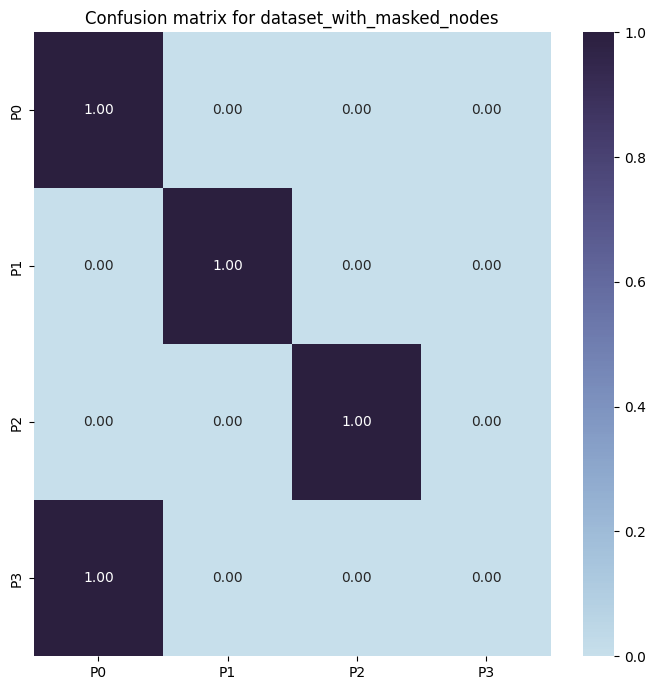

In [68]:
results_masked = trainer_mask.run()

In [69]:
# hm, we got worse precision
results_masked

{'f1_macro': 0.7,
 'f1_weighted': 0.8444444444444444,
 'precision_macro': 0.6666666666666666,
 'precision_weighted': 0.8148148148148148,
 'recall_macro': 0.75,
 'recall_weighted': 0.8888888888888888,
 'accuracy': 0.8888888888888888,
 'class_scores': {'P0': 0.8, 'P1': 1.0, 'P2': 1.0, 'P3': 0.0},
 'skipped_nodes': 0,
 'memory_allocated_MB': 40.77490234375,
 'memory_reserved_MB': 50.0}

In [70]:
# let's visualise misprediction
the_graph_i_want_to_see = 8
print(f'Current test node: {dp_mask.test_nodes[the_graph_i_want_to_see]}, assign this values to test_node variable below')

Current test node: 38, assign this values to test_node variable below


Number of initial nodes: 40
Number of final nodes: 13


/disk/10tb/home/shmelev/GENLINK/utils/genlink.py:1902: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter([],[], c=clr, label=f'{self.class_to_int_mapping[i]}')
/disk/10tb/home/shmelev/GENLINK/utils/genlink.py:1903: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter([],[], c=clr, label=f'{self.class_to_int_mapping[i]}')


<Figure size 640x480 with 0 Axes>

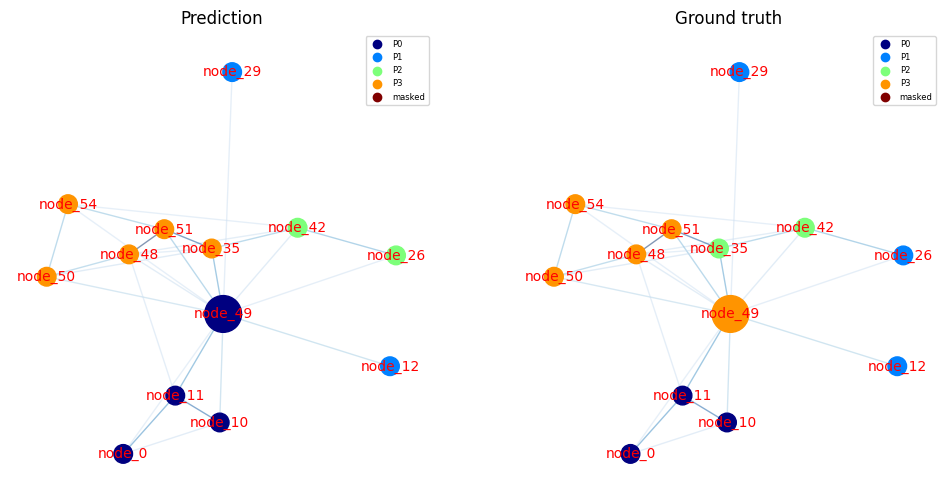

In [71]:
dp_mask.visualize_predictions(model=trainer_mask.model,
                         test_graph=dp_mask.array_of_graphs_for_testing[the_graph_i_want_to_see],
                         test_node=dp_mask.test_nodes[the_graph_i_want_to_see], 
                         node_labels_size=10, 
                         node_label_font_color='red',
                         node_labels='real',
                         base_node_size=180,
                         selected_node_size=700,
                         use_component=False)

In my opinion, decision of GNN looks pretty reasonable (the node_49 has strong connection with nodes from population P0). However, without masked nodes model gave correct prediction before (seems like this graph is too small to get real benefits from masked nodes; the test set it too small). Anyway, it is pleasure to see that the model didn't decide to assign classes P1 or P2 for node_49 because it's clearly not true (weak connection weights and small amount of neighbours with such classes). Note that "masked" nodes in "Ground truth" section have it own colors but are circles. Instead, "masked" nodes in "Prediction" section are drawn as squares

Number of initial nodes: 40
Number of connected components:2
Number of final nodes: 39
Using masks


<Figure size 640x480 with 0 Axes>

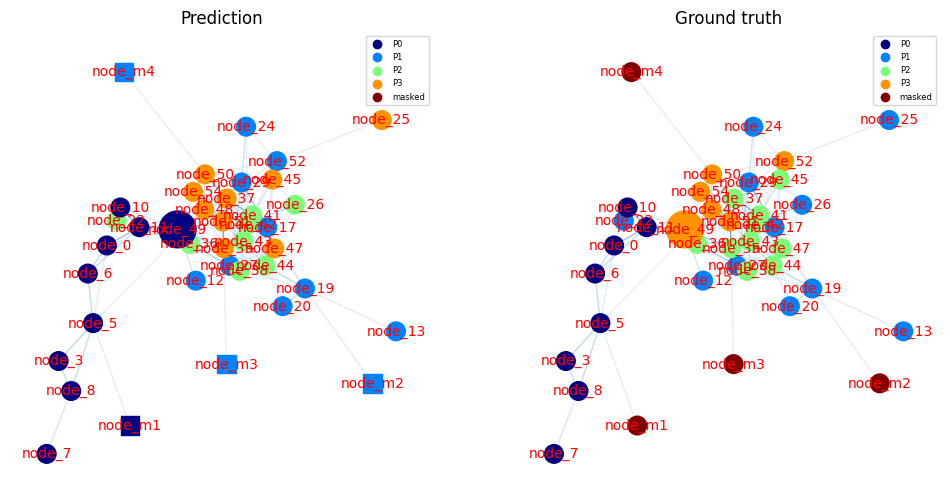

In [72]:
dp_mask.visualize_predictions(model=trainer_mask.model,
                         test_graph=dp_mask.array_of_graphs_for_testing[the_graph_i_want_to_see],
                         test_node=dp_mask.test_nodes[the_graph_i_want_to_see], 
                         node_labels_size=10, 
                         node_label_font_color='red',
                         node_labels='real',
                         base_node_size=180,
                         selected_node_size=700,
                         use_component=True)

# Prediction on custom graphs with masks

Let's try the following trick: we will add one more node to our graph with masks but this node will be connected only with one masked node. It is impossible to handle such situation with heuristics. However, our GNN should give correct prediction even over the masked node (at least at some cases). If it not gives good results for you, try different architecture of the model (architecture is really important here) or train model with different parameters

In [73]:
df_mod_mask

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n
0,node_1,node_0,P0,P0,79.181347,1
1,node_2,node_0,P0,P0,9.701131,1
2,node_4,node_0,P0,P0,28.309291,1
3,node_5,node_0,P0,P0,14.826807,1
4,node_5,node_2,P0,P0,11.424783,1
...,...,...,...,...,...,...
234,node_55,node_54,P3,P3,15.175590,1
235,node_m1,node_5,masked,P0,10.000000,1
236,node_m2,node_19,masked,P1,10.000000,1
237,node_m3,node_35,masked,P2,10.000000,1


In [74]:
df_over_mask_node = pd.DataFrame({'node_id1':['node_om1'], 
                       'node_id2':['node_m4'], 
                       'label_id1':['P0'], # remember, we can use here whatever class, it's so called "fake targets"
                       'label_id2':['masked'],
                       'ibd_sum':[10.0], # we use arbitrary values here just as example
                       'ibd_n':[1]})
df_over_mask_node

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n
0,node_om1,node_m4,P0,masked,10.0,1


In [75]:
# now we merge all those dataframes
df_mod_over_mask = pd.concat([df_mod_mask, df_over_mask_node], axis=0)
df_mod_over_mask = df_mod_over_mask.reset_index(drop=True)
df_mod_over_mask

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n
0,node_1,node_0,P0,P0,79.181347,1
1,node_2,node_0,P0,P0,9.701131,1
2,node_4,node_0,P0,P0,28.309291,1
3,node_5,node_0,P0,P0,14.826807,1
4,node_5,node_2,P0,P0,11.424783,1
...,...,...,...,...,...,...
235,node_m1,node_5,masked,P0,10.000000,1
236,node_m2,node_19,masked,P1,10.000000,1
237,node_m3,node_35,masked,P2,10.000000,1
238,node_50,node_m4,P3,masked,10.000000,1


In [76]:
dp_over_mask = DataProcessor(path=df_mod_over_mask,
                    is_path_object=True,
                    disable_printing=False,
                    dataset_name='dataset_with_one_over_masked_nodes',
                    no_mask_class_in_df=False) # pay attention here,  we have "masked" node in dataframe

In [77]:
dp_over_mask.load_partitions(train_socket=[dp_mask.int_to_node_names_mapping[node] for node in dp_mask.train_nodes],
                    valid_socket=[], # be carefull with that, do not use empty array of valid nodes during normal training
                    test_socket=['node_om1'],
                    mask_socket=[dp_mask.int_to_node_names_mapping[node] for node in dp_mask.mask_nodes])

In [78]:
dp_over_mask.make_train_valid_test_datasets_with_numba(feature_type='one_hot', 
                                             model_type='homogeneous', 
                                             train_dataset_type='multiple', 
                                             test_dataset_type='multiple',
                                             log_edge_weights=False,
                                             skip_train_val=True, # keep it in mind
                                             masking=True, # don't forget it
                                             no_mask_class_in_df=False, # don't forget it
                                             make_ram_efficient_dataset=False)

Make test samples: 100%|██████████| 1/1 [00:00<00:00, 300.00it/s]


In [79]:
# make sure the core of the graph (that should consist only from the train nodes) is the same

dp_over_mask_test_graph = to_networkx(dp_over_mask.array_of_graphs_for_testing[0], edge_attrs=['weight'], node_attrs=['y', 'mask'], to_undirected=True)
dp_mask_train_graph = to_networkx(dp_mask.array_of_graphs_for_training[0], edge_attrs=['weight'], node_attrs=['y', 'mask'], to_undirected=True)

dp_over_mask_test_graph = nx.subgraph(dp_over_mask_test_graph, list(range(len(dp_over_mask_test_graph.nodes) - 1))) # we can do this because validation and test nodes always have the last idx in graph, so we just substract 1

assert nx.vf2pp_is_isomorphic(dp_mask_train_graph, dp_over_mask_test_graph)

In [80]:
trainer_over_mask = Trainer(data=dp_over_mask, # don't forget to change DataProcessor object here
        model_cls=GL_TAGConv_3l_512h_w_k3_gnorm, 
        lr=0.0001, 
        wd=0.0001, 
        loss_fn=torch.nn.CrossEntropyLoss, 
        batch_size=10, 
        log_dir=f'{os.environ.get("HOME")}/GENLINK/data/tutorial/one_hot_with_masks', 
        patience=10, 
        num_epochs=10, 
        feature_type='one_hot', 
        train_iterations_per_sample=None, 
        evaluation_steps=None, 
        weight=[None],
        masking=True, # must be True here
        cuda_device_specified=0,
        disable_printing=False,
        seed=seed, 
        save_model_in_ram=True, 
        correct_and_smooth=False, 
        no_mask_class_in_df=False, # must be False here
        remove_saved_model_after_testing=False,
        plot_cm=True,
        use_class_balance_weight=True,
        num_workers=2)

Using loss weights according to class balance excluding masked class


In [81]:
answers = trainer_over_mask.load_model_and_get_predictions(path=f'{os.environ.get("HOME")}/GENLINK/data/tutorial/one_hot_with_masks/model_best.bin')

**And the answer is correct!!!** Why? Yeah, I remember that we assigned the class P0 for this node but remebmer that was so called "fake target", this does not affect prediction because it is a test node. But what you should remember is that we connected our node `node_om1` only with masked node `node_m4` but this node `node_m4` was previously connected only with node `node_50` which has class P3. So, the class propagation throug "masked" node was absolutely logical and clear

In [82]:
answers

{'test_graph_0': {'answer_class': 'P3',
  'answer_id': 3,
  'probabilities': array([0.12716776, 0.27118888, 0.04508222, 0.5565611 ], dtype=float32)}}

In [83]:
the_graph_i_want_to_see = 0
print(f'Current test node: {dp_over_mask.test_nodes[the_graph_i_want_to_see]}, assign this values to test_node variable below')

Current test node: 48, assign this values to test_node variable below


Number of initial nodes: 40
Number of connected components:2
Number of final nodes: 39
Using masks


/disk/10tb/home/shmelev/GENLINK/utils/genlink.py:1902: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter([],[], c=clr, label=f'{self.class_to_int_mapping[i]}')
/disk/10tb/home/shmelev/GENLINK/utils/genlink.py:1903: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter([],[], c=clr, label=f'{self.class_to_int_mapping[i]}')


<Figure size 640x480 with 0 Axes>

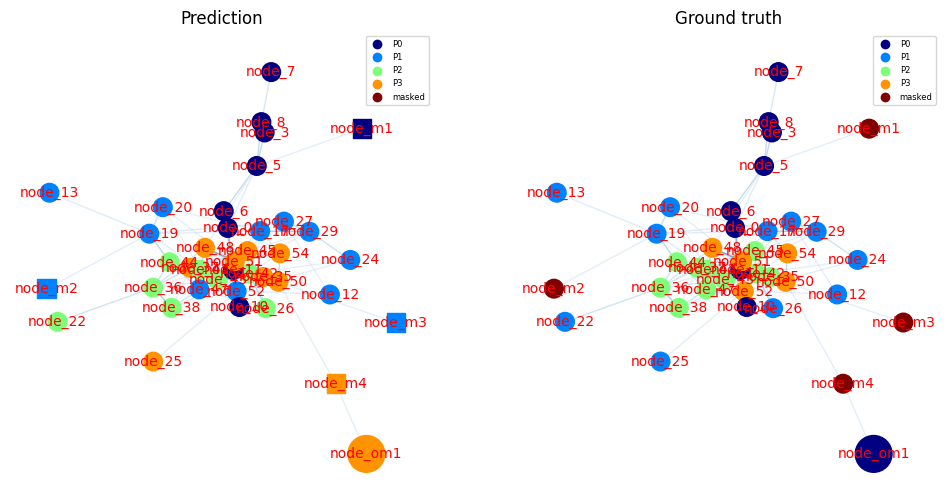

In [84]:
# if it is not clearly visible, try to run this cell multiple times
# we even fixed the predicted class of node node_m4

dp_over_mask.visualize_predictions(model=trainer_over_mask.model,
                         test_graph=dp_over_mask.array_of_graphs_for_testing[the_graph_i_want_to_see],
                         test_node=dp_over_mask.test_nodes[the_graph_i_want_to_see], 
                         node_labels_size=10, 
                         node_label_font_color='red',
                         node_labels='real',
                         base_node_size=180,
                         selected_node_size=700,
                         use_component=True)

# Training and validation using graph_based features

Along with one_hot node features graph_based features can be used with "masked" nodes or without "masked" nodes. Here is how to use it (we will use our initial graph as example)

In [85]:
dp_gb = DataProcessor(path=graph_file_path,
                   is_path_object=False,
                   disable_printing=False,
                   dataset_name='tutorial_dataset_graph_based',
                   no_mask_class_in_df=True)

In [86]:
dp_gb.generate_random_train_valid_test_nodes(train_size=0.6,
                                          valid_size=0.2, 
                                          test_size=0.2, 
                                          random_state=seed,
                                          save_dir=None,
                                          mask_size=None,
                                          sub_train_size=None,
                                          keep_train_nodes=None,
                                          mask_random_state=None)

100.0% (55) of all nodes in dataset were used to create splits (no masked nodes assumed)


In [87]:
dp_gb.make_train_valid_test_datasets_with_numba(feature_type='graph_based', # pay attention here
                                             model_type='homogeneous', 
                                             train_dataset_type='one', # extremely important
                                             test_dataset_type='multiple',
                                             log_edge_weights=False,
                                             skip_train_val=False,
                                             masking=False,
                                             no_mask_class_in_df=True,
                                             make_ram_efficient_dataset=False)

Make test samples: 100%|██████████| 9/9 [00:00<00:00, 515.04it/s]


Let's look at the node features

In [88]:
dp_gb.array_of_graphs_for_training[0]

Data(x=[35, 16], edge_index=[2, 184], y=[35], weight=[184], mask=[35], num_classes=4)

In [89]:
dp_gb.array_of_graphs_for_training[0].x

tensor([[  0.0000,   3.0000,   7.0000,   2.0000,   0.0000,  21.4553,  37.0134,
           8.3843,   0.0000,  18.5497,  28.1737,   1.7391,   0.0000,  47.6885,
          92.5662,  10.1234],
        [  1.0000,   0.0000,   0.0000,   0.0000,  22.6925,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  22.6925,   0.0000,
           0.0000,   0.0000],
        [  0.0000,   1.0000,   5.0000,   1.0000,   0.0000,  10.8645,  50.8261,
           9.6409,   0.0000,   0.0000,  25.8289,   0.0000,   0.0000,  10.8645,
          80.9713,   9.6409],
        [  0.0000,   0.0000,   1.0000,   0.0000,   0.0000,   0.0000,  29.3209,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          29.3209,   0.0000],
        [  0.0000,   3.0000,   2.0000,   0.0000,   0.0000,  42.9468,  11.1268,
           0.0000,   0.0000,  14.1873,   0.2624,   0.0000,   0.0000,  62.6750,
          11.3892,   0.0000],
        [  0.0000,   3.0000,   1.0000,   2.0000,   0.0000,  

In [90]:
print(f'Here is the node features {dp_gb.array_of_graphs_for_training[0].x[0]} for the node {dp_gb.train_nodes[0]} (node {dp_gb.int_to_node_names_mapping[dp_gb.train_nodes[0]]})')

Here is the node features tensor([ 0.0000,  3.0000,  7.0000,  2.0000,  0.0000, 21.4553, 37.0134,  8.3843,
         0.0000, 18.5497, 28.1737,  1.7391,  0.0000, 47.6885, 92.5662, 10.1234],
       dtype=torch.float64) for the node 31 (node node_42)


Here is what we have in our dataframe for this node (filtering with training nodes)

In [91]:
original_train_nodes = [dp_gb.int_to_node_names_mapping[node] for node in dp_gb.train_nodes]

In [92]:
df_init[(df_init['node_id1'] == 'node_42') & (df_init['node_id2'].isin(original_train_nodes)) | (df_init['node_id2'] == 'node_42') & (df_init['node_id1'].isin(original_train_nodes))]

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n
93,node_42,node_20,P2,P1,8.290632,1
94,node_42,node_24,P2,P1,8.386944,1
95,node_42,node_26,P2,P1,47.688465,1
97,node_42,node_35,P2,P2,40.318483,1
98,node_42,node_37,P2,P2,15.289579,1
99,node_42,node_38,P2,P2,21.023405,1
100,node_42,node_41,P2,P2,92.566169,1
109,node_43,node_42,P2,P2,61.191729,1
118,node_44,node_42,P2,P2,6.606104,1
127,node_45,node_42,P2,P2,22.098474,1


In [93]:
print(f'Mean edge weight between P2 and P1: {np.mean([8.290632, 8.386944, 47.688465])}')
print(f'Mean edge weight between P2 and P2: {np.mean([40.318483, 15.289579, 21.023405, 92.566169, 61.191729, 6.606104, 22.098474])}')
print(f'Mean edge weight between P2 and P3: {np.mean([10.123405, 6.645182])}')
print(f'Stddev of weights between P2 and P1: {np.std([8.290632, 8.386944, 47.688465])}')
print(f'Stddev of weights between P2 and P2: {np.std([40.318483, 15.289579, 21.023405, 92.566169, 61.191729, 6.606104, 22.098474])}')
print(f'Stddev of weights between P2 and P3: {np.std([10.123405, 6.645182])}')
print(f'Max of weights between P2 and P1: {np.max([8.290632, 8.386944, 47.688465])}')
print(f'Max of weights between P2 and P2: {np.max([40.318483, 15.289579, 21.023405, 92.566169, 61.191729, 6.606104, 22.098474])}')
print(f'Max of weights between P2 and P3: {np.max([10.123405, 6.645182])}')

Mean edge weight between P2 and P1: 21.455347
Mean edge weight between P2 and P2: 37.01342042857142
Mean edge weight between P2 and P3: 8.3842935
Stddev of weights between P2 and P1: 18.549657301448615
Stddev of weights between P2 and P2: 28.17366631902597
Stddev of weights between P2 and P3: 1.7391115
Max of weights between P2 and P1: 47.688465
Max of weights between P2 and P2: 92.566169
Max of weights between P2 and P3: 10.123405


Let's calculate everything manually. Let array of features be $X$. Then

* $X[0]$ - 0 is correct because node_42 has no connections with class P0
* $X[1]$ - 3 is correct because node_42 has 3 connections with class P1 (node_20, node_24, node_26)
* $X[2]$ - 7 is correct because node_42 has no connections with class P2 (node_35, node_37, node_38, node_41, node_43, node_44, node_45)
* $X[3]$ - 2 is correct because node_42 has no connections with class P3 (node_48, node_54)
* $X[4]$ - 0 is correct because mean edge weight between class P2 (node_42) and P0 is 0 (no nodes)
* $X[5]$ - 21.45 is correct because mean edge weight between class P2 (node_42) and P1 is 21.45 (see code above)
* $X[6]$ - 37.01 is correct because mean edge weight between class P2 (node_42) and P2 is 37.01 (see code above)
* $X[7]$ - 8.38 is correct because mean edge weight between class P2 (node_42) and P3 is 8.38 (see code above)
* $X[8]$ - 0 is correct because stddev of weights between class P2 (node_42) and P0 is 0 (no nodes)
* $X[9]$ - 18.54 is correct because stddev of weights between class P2 (node_42) and P1 is 18.54 (see code above)
* $X[10]$ - 28.17 is correct because stddev of weights between class P2 (node_42) and P2 is 28.17 (see code above)
* $X[11]$ - 1.73 is correct because stddev of weights between class P2 (node_42) and P3 is 1.73 (see code above)
* $X[12]$ - 0 is correct because max of weights between class P2 (node_42) and P0 is 0 (no nodes)
* $X[13]$ - 47.68 is correct because max of weights between class P2 (node_42) and P1 is 47.68 (see code above)
* $X[14]$ - 92.56 is correct because max of weights between class P2 (node_42) and P2 is 92.56 (see code above)
* $X[15]$ - 10.12 is correct because max of weights between class P2 (node_42) and P3 is 10.12 (see code above)

Make sure that edges to validation and test nodes do not contribute in train node features (otherwise it is a data leak)

In [94]:
graph_based_train_graph_x = dp_gb.array_of_graphs_for_training[0].x

# checking validation graphs
for graph_based_valid_graph in dp_gb.array_of_graphs_for_validation:
    torch.allclose(graph_based_train_graph_x, graph_based_valid_graph.x[:-1])

# checking test graphs
for graph_based_test_graph in dp_gb.array_of_graphs_for_testing:
    torch.allclose(graph_based_train_graph_x, graph_based_test_graph.x[:-1])

For validation/test nodes you can calculate features manually as well (example below)

In [95]:
# 8-th graph in array of test graphs belongs to node_49 (we already discussed it above)
df_init[(df_init['node_id1'] == 'node_49') & (df_init['node_id2'].isin(original_train_nodes)) | (df_init['node_id2'] == 'node_49') & (df_init['node_id1'].isin(original_train_nodes))]

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n
163,node_49,node_0,P3,P0,6.134759,1
164,node_49,node_10,P3,P0,26.063956,1
165,node_49,node_11,P3,P0,61.522664,1
166,node_49,node_12,P3,P1,27.315532,1
168,node_49,node_26,P3,P1,9.290761,1
169,node_49,node_29,P3,P1,8.581313,1
172,node_49,node_35,P3,P2,58.302246,1
175,node_49,node_42,P3,P2,13.524648,1
176,node_49,node_48,P3,P3,12.230107,1
181,node_50,node_49,P3,P3,22.277256,1


In [96]:
# see last row there
dp_gb.array_of_graphs_for_testing[8].x

tensor([[  0.0000,   3.0000,   7.0000,   2.0000,   0.0000,  21.4553,  37.0134,
           8.3843,   0.0000,  18.5497,  28.1737,   1.7391,   0.0000,  47.6885,
          92.5662,  10.1234],
        [  1.0000,   0.0000,   0.0000,   0.0000,  22.6925,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  22.6925,   0.0000,
           0.0000,   0.0000],
        [  0.0000,   1.0000,   5.0000,   1.0000,   0.0000,  10.8645,  50.8261,
           9.6409,   0.0000,   0.0000,  25.8289,   0.0000,   0.0000,  10.8645,
          80.9713,   9.6409],
        [  0.0000,   0.0000,   1.0000,   0.0000,   0.0000,   0.0000,  29.3209,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          29.3209,   0.0000],
        [  0.0000,   3.0000,   2.0000,   0.0000,   0.0000,  42.9468,  11.1268,
           0.0000,   0.0000,  14.1873,   0.2624,   0.0000,   0.0000,  62.6750,
          11.3892,   0.0000],
        [  0.0000,   3.0000,   1.0000,   2.0000,   0.0000,  

Time to run training!!!

In [97]:
# the same as for one hot but with a few changes (see comments)
trainer_graph_based = Trainer(data=dp_gb, # don't forget to change DataProcessor object
        model_cls=GL_TAGConv_3l_512h_w_k3_gnorm, 
        lr=0.0001, 
        wd=0.0001, 
        loss_fn=torch.nn.CrossEntropyLoss, 
        batch_size=10, 
        log_dir=f'{os.environ.get("HOME")}/GENLINK/data/tutorial/graph_based_without_masks', 
        patience=10, 
        num_epochs=10, # this parameter is not taken into account with graph_based features, see train_iterations_per_sample instead
        feature_type='graph_based', # pay attention here
        train_iterations_per_sample=1000, # pay attention here
        evaluation_steps=10, # pay attention here
        weight=[None],
        masking=False, # if you want to use it with masked nodes, set it to True
        cuda_device_specified=0,
        disable_printing=False,
        seed=seed, 
        save_model_in_ram=True, 
        correct_and_smooth=False, 
        no_mask_class_in_df=True, # if you want to use it with masked nodes, set it to False
        remove_saved_model_after_testing=False,
        plot_cm=True,
        use_class_balance_weight=True,
        num_workers=2)

Using loss weights according to class balance


Training for data: tutorial_dataset_graph_based


Compute metrics: 100%|██████████| 11/11 [00:00<00:00, 39.35it/s]
/disk/10tb/home/shmelev/miniconda3/envs/genlink/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/disk/10tb/home/shmelev/miniconda3/envs/genlink/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/disk/10tb/home/shmelev/miniconda3/envs/genlink/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `

Evaluation report
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.20      0.25      0.22         4
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         2

    accuracy                           0.27        11
   macro avg       0.22      0.31      0.26        11
weighted avg       0.19      0.27      0.23        11

f1 macro score on valid dataset for class 0 which is P0: 0.8
f1 macro score on valid dataset for class 1 which is P1: 0.2222222222222222
f1 macro score on valid dataset for class 2 which is P2: 0.0
f1 macro score on valid dataset for class 3 which is P3: 0.0
f1 macro improvement to 0.25555555555555554


Training iterations:   1%|          | 11/1000 [00:00<00:55, 17.70it/s]

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.75      0.86         4
           2       1.00      0.67      0.80         3
           3       0.50      1.00      0.67         2

    accuracy                           0.82        11
   macro avg       0.88      0.85      0.83        11
weighted avg       0.91      0.82      0.83        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 0.8571428571428571
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.6666666666666666
f1 macro improvement to 0.830952380952381


Training iterations:   2%|▏         | 21/1000 [00:01<00:44, 22.19it/s]

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.75      0.86         4
           2       1.00      0.67      0.80         3
           3       0.50      1.00      0.67         2

    accuracy                           0.82        11
   macro avg       0.88      0.85      0.83        11
weighted avg       0.91      0.82      0.83        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 0.8571428571428571
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.6666666666666666
Metric was not improved for the 1th time


Training iterations:   3%|▎         | 31/1000 [00:01<00:40, 23.99it/s]

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.75      0.86         4
           2       1.00      0.67      0.80         3
           3       0.50      1.00      0.67         2

    accuracy                           0.82        11
   macro avg       0.88      0.85      0.83        11
weighted avg       0.91      0.82      0.83        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 0.8571428571428571
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.6666666666666666
Metric was not improved for the 2th time


Training iterations:   4%|▍         | 41/1000 [00:01<00:38, 24.95it/s]

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.75      0.86         4
           2       1.00      0.67      0.80         3
           3       0.50      1.00      0.67         2

    accuracy                           0.82        11
   macro avg       0.88      0.85      0.83        11
weighted avg       0.91      0.82      0.83        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 0.8571428571428571
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.6666666666666666
Metric was not improved for the 3th time


Training iterations:   5%|▌         | 51/1000 [00:02<00:36, 25.76it/s]

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.75      0.86         4
           2       1.00      0.67      0.80         3
           3       0.50      1.00      0.67         2

    accuracy                           0.82        11
   macro avg       0.88      0.85      0.83        11
weighted avg       0.91      0.82      0.83        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 0.8571428571428571
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.6666666666666666
Metric was not improved for the 4th time


Training iterations:   6%|▌         | 61/1000 [00:02<00:35, 26.11it/s]

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.75      0.86         4
           2       1.00      0.67      0.80         3
           3       0.50      1.00      0.67         2

    accuracy                           0.82        11
   macro avg       0.88      0.85      0.83        11
weighted avg       0.91      0.82      0.83        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 0.8571428571428571
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.6666666666666666
Metric was not improved for the 5th time


Training iterations:   7%|▋         | 71/1000 [00:02<00:35, 26.21it/s]

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.75      0.86         4
           2       1.00      0.67      0.80         3
           3       0.50      1.00      0.67         2

    accuracy                           0.82        11
   macro avg       0.88      0.85      0.83        11
weighted avg       0.91      0.82      0.83        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 0.8571428571428571
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.6666666666666666
Metric was not improved for the 6th time


Training iterations:   8%|▊         | 81/1000 [00:03<00:34, 26.40it/s]

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.75      0.86         4
           2       1.00      0.67      0.80         3
           3       0.50      1.00      0.67         2

    accuracy                           0.82        11
   macro avg       0.88      0.85      0.83        11
weighted avg       0.91      0.82      0.83        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 0.8571428571428571
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.6666666666666666
Metric was not improved for the 7th time


Training iterations:   9%|▉         | 91/1000 [00:03<00:33, 26.85it/s]

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.75      0.86         4
           2       1.00      0.67      0.80         3
           3       0.50      1.00      0.67         2

    accuracy                           0.82        11
   macro avg       0.88      0.85      0.83        11
weighted avg       0.91      0.82      0.83        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 0.8571428571428571
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.6666666666666666
Metric was not improved for the 8th time


Training iterations:  10%|█         | 101/1000 [00:04<00:33, 27.17it/s]

Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.75      0.86         4
           2       1.00      0.67      0.80         3
           3       0.50      1.00      0.67         2

    accuracy                           0.82        11
   macro avg       0.88      0.85      0.83        11
weighted avg       0.91      0.82      0.83        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 0.8571428571428571
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.6666666666666666
Metric was not improved for the 9th time


Training iterations:  11%|█         | 111/1000 [00:04<00:35, 25.26it/s]


Evaluation report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.75      0.86         4
           2       1.00      0.67      0.80         3
           3       0.50      1.00      0.67         2

    accuracy                           0.82        11
   macro avg       0.88      0.85      0.83        11
weighted avg       0.91      0.82      0.83        11

f1 macro score on valid dataset for class 0 which is P0: 1.0
f1 macro score on valid dataset for class 1 which is P1: 0.8571428571428571
f1 macro score on valid dataset for class 2 which is P2: 0.8
f1 macro score on valid dataset for class 3 which is P3: 0.6666666666666666
Metric was not improved for the 10th time


Compute metrics: 100%|██████████| 9/9 [00:00<00:00, 35.19it/s]


Test report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         1

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9

f1 macro score on test dataset: 1.0
f1 weighted score on test dataset: 1.0
recall macro score on test dataset: 1.0
recall weighted score on test dataset: 1.0
recall macro score on test dataset: 1.0
recall weighted score on test dataset: 1.0
accuracy score on test dataset: 1.0
f1 macro score on test dataset for class 0 which is P0: 1.0
f1 macro score on test dataset for class 1 which is P1: 1.0
f1 macro score on test dataset for class 2 which is P2: 1.0
f1 macro score on test dataset for class 3 which is P3: 1.0


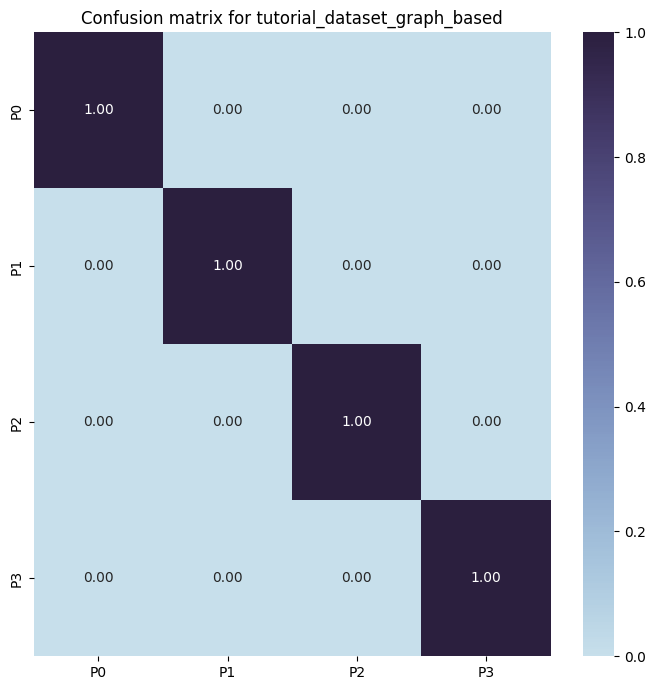

In [98]:
answers_graph_based = trainer_graph_based.run()

In [105]:
the_graph_i_want_to_see = 0
print(f'Current test node: {dp_gb.test_nodes[the_graph_i_want_to_see]}, assign this values to test_node variable below')

Current test node: 2, assign this values to test_node variable below


Number of initial nodes: 36
Number of final nodes: 6


<Figure size 640x480 with 0 Axes>

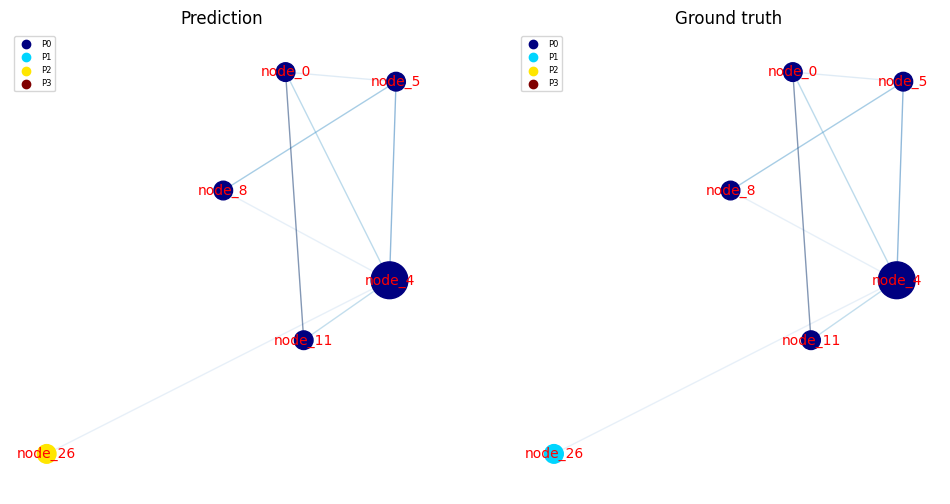

In [106]:
dp_gb.visualize_predictions(model=trainer_graph_based.model,
                         test_graph=dp_gb.array_of_graphs_for_testing[the_graph_i_want_to_see],
                         test_node=dp_gb.test_nodes[the_graph_i_want_to_see], 
                         node_labels_size=10, 
                         node_label_font_color='red',
                         node_labels='real',
                         base_node_size=180,
                         selected_node_size=700,
                         use_component=False)